# BDT Model Training for Photon Identification

This notebook focuses on training a Boosted Decision Tree (BDT) using XGBoost for photon vs. jet discrimination.

## 1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.interpolate import UnivariateSpline
import ROOT

## 2. Load and Prepare Data

In [ ]:
# Define column names
columns = [
    "cluster_Et", "cluster_Eta", "cluster_Phi", "vertexz",
    "e11_over_e33", "e32_over_e35", "e11_over_e22", "e11_over_e13",
    "e11_over_e15", "e11_over_e17", "e11_over_e31",
    "e11_over_e51", "e11_over_e71", "e22_over_e33",
    "e22_over_e35", "e22_over_e37", "e22_over_e53",
    "cluster_prob", "cluster_weta_cogx", "cluster_wphi_cogx",
    "cluster_et1", "cluster_et2", "cluster_et3", "cluster_et4",
    "cluster_w32", "cluster_w52", "cluster_w72", 
    "recoisoET", "is_tight", "pid"
]

# Load signal and background data
df_sig = pd.read_csv("shapes_photon20.txt", sep=r"\s+", header=0, names=columns)
df_bkg = pd.read_csv("shapes_jet30.txt", sep=r"\s+", header=0, names=columns)

# Convert pid to numeric and filter
df_sig["pid"] = pd.to_numeric(df_sig["pid"], errors="coerce")
df_bkg["pid"] = pd.to_numeric(df_bkg["pid"], errors="coerce")

# Keep only photons for signal, reject electrons for background
df_sig = df_sig[df_sig["pid"].isin([1,2])]  # photon only
df_bkg = df_bkg[~df_bkg["pid"].isin([1,2])] 

# Assign labels
df_sig["label"] = 1
df_bkg["label"] = 0

# Combine datasets
df = pd.concat([df_sig, df_bkg], ignore_index=True)

print(f"Signal samples: {len(df_sig)}")
print(f"Background samples: {len(df_bkg)}")
print(f"Total samples: {len(df)}")

## Kinematic Reweighting (Et and Eta)

In [ ]:
# Parameters for Et reweighting
et_min, et_max = 10, 30
n_bins = 40
bin_width = (et_max - et_min)/n_bins
bins = np.linspace(et_min, et_max, n_bins + 1)

# Filter data within Et range
df_weighted = df.loc[df["cluster_Et"].between(et_min, et_max, inclusive="both")].copy()

# Apply Et reweighting
for label in [0, 1]:
    label_name = "Background" if label == 0 else "Signal"
    mask = df_weighted["label"] == label
    values = df_weighted.loc[mask, "cluster_Et"].values

    # Histogram for PDF estimation
    hist, bin_edges = np.histogram(values, bins=bins, density=True)
    x_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Fit Spline to Histogram
    spline = UnivariateSpline(x_centers, hist, s=0.0)
    pdf_vals = spline(values)
    pdf_vals = np.clip(pdf_vals, a_min=1e-3, a_max=None)

    # Inverse-PDF weights
    weights = 1.0 / pdf_vals
    weights /= np.mean(weights)
    
    # For now, turn off reweighting (weights = 1)
    weights = weights/weights
    if label == 1:
        weights = weights * 1  # class balance factor if needed

    df_weighted.loc[mask, "weight"] = weights

print(f"Applied Et reweighting to {len(df_weighted)} samples")

In [ ]:
# Parameters for Eta reweighting
eta_min, eta_max = -0.7, 0.7
n_bins_eta = 20
bins_eta = np.linspace(eta_min, eta_max, n_bins_eta + 1)

# Apply Eta reweighting on top of Et weights
for label in [0, 1]:
    label_name = "Background" if label == 0 else "Signal"
    mask = df_weighted["label"] == label
    eta_vals = df_weighted.loc[mask, "cluster_Eta"].values

    # Histogram for eta PDF
    hist_eta, bin_edges_eta = np.histogram(eta_vals, bins=bins_eta, density=True)
    x_centers_eta = 0.5 * (bin_edges_eta[:-1] + bin_edges_eta[1:])

    # Fit spline to eta PDF
    spline_eta = UnivariateSpline(x_centers_eta, hist_eta, s=0.0)
    pdf_eta_vals = spline_eta(eta_vals)
    pdf_eta_vals = np.clip(pdf_eta_vals, a_min=1e-3, a_max=None)

    # Compute inverse PDF weights for eta
    weights_eta = 1.0 / pdf_eta_vals
    weights_eta /= np.mean(weights_eta)

    if label == 1:
        weights_eta *= 1  # class balancing factor if needed

    # Combine with existing Et weights
    df_weighted.loc[mask, "weight"] *= weights_eta

print(f"Applied Eta reweighting. Final weighted dataset: {len(df_weighted)} samples")

## Train-Test Split

In [69]:
# Define features to use for training
features = [
    "vertexz", 
    #"cluster_Eta",
    "e11_over_e33", 
    "cluster_et1", 
    "cluster_et2", 
    "cluster_et3", 
    "cluster_et4",
]
et_min_train = 10
et_max_train = 30
# Convert all features to numeric and drop invalid rows from the ET-filtered dataset
for col in features:
    df_weighted[col] = pd.to_numeric(df_weighted[col], errors="coerce")

# filter based on Et
df_weighted = df_weighted[(df_weighted["cluster_Et"] >= et_min_train) & (df_weighted["cluster_Et"] <= et_max_train)]

# Drop rows with NaN values in features or label from the filtered dataset
df_weighted.dropna(subset=features + ["label"], inplace=True)

print(f"Features selected: {features}")
print(f"Samples after Et filtering (10-30 GeV): {len(df_weighted)}")
print(f"Et range applied: {et_min_train}-{et_max_train} GeV")

# Prepare arrays for training from Et-filtered dataset
X = df_weighted[features].to_numpy(dtype=np.float32) 
y = df_weighted["label"].to_numpy(dtype=np.int32)
w = df_weighted["weight"].to_numpy(dtype=np.float32) 

# Train/test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.2, random_state=42, stratify=y
)

# Check label distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Training set label distribution:", dict(zip(unique, counts)))
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Features selected: ['vertexz', 'e11_over_e33', 'cluster_et1', 'cluster_et2', 'cluster_et3', 'cluster_et4']
Samples after Et filtering (10-30 GeV): 1606806
Et range applied: 10-30 GeV
Training set label distribution: {np.int32(0): np.int64(249315), np.int32(1): np.int64(1036129)}
Training samples: 1285444
Testing samples: 321362
Training set label distribution: {np.int32(0): np.int64(249315), np.int32(1): np.int64(1036129)}
Training samples: 1285444
Testing samples: 321362


## Feature Distribution Analysis

Visualizing the distribution of each feature for signal and background to understand separating power and potential biases.

In [ ]:
# Feature Distribution Plots for Signal vs Background
import matplotlib.pyplot as plt
import numpy as np

# Separate signal and background from the weighted dataset
signal_mask = df_weighted["label"] == 1
background_mask = df_weighted["label"] == 0

print("=== FEATURE DISTRIBUTION ANALYSIS ===")
print(f"Signal samples: {np.sum(signal_mask):,}")
print(f"Background samples: {np.sum(background_mask):,}")
print(f"Features to analyze: {features}")

# Calculate number of rows and columns for subplot layout
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

# Flatten axes for easy iteration
axes_flat = axes.flatten()

# Plot each feature distribution
for idx, feature in enumerate(features):
    ax = axes_flat[idx]
    
    # Get feature data for signal and background
    signal_data = df_weighted.loc[signal_mask, feature].values
    background_data = df_weighted.loc[background_mask, feature].values
    signal_weights = df_weighted.loc[signal_mask, "weight"].values
    background_weights = df_weighted.loc[background_mask, "weight"].values
    
    # Remove NaN values
    signal_finite = np.isfinite(signal_data)
    background_finite = np.isfinite(background_data)
    
    signal_clean = signal_data[signal_finite]
    background_clean = background_data[background_finite]
    signal_weights_clean = signal_weights[signal_finite]
    background_weights_clean = background_weights[background_finite]
    
    if len(signal_clean) == 0 or len(background_clean) == 0:
        ax.text(0.5, 0.5, f"No valid data for {feature}", ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"{feature} (No Data)")
        continue
    
    # Determine histogram range based on data
    all_data = np.concatenate([signal_clean, background_clean])
    if len(all_data) > 0:
        # Use percentiles to avoid outlier effects
        q1, q99 = np.percentile(all_data, [1, 99])
        
        # Special handling for specific features
        if feature == "vertexz":
            bins = np.linspace(-35, 35, 40)
        elif feature == "cluster_Eta":
            bins = np.linspace(-0.8, 0.8, 40)
        elif "cluster_et" in feature.lower():
            bins = np.linspace(0, max(20, q99*1.1), 40)
        else:
            bins = np.linspace(q1, q99, 40)
    else:
        bins = 40
    
    # Plot overlaid histograms
    ax.hist(background_clean, bins=bins, weights=background_weights_clean, alpha=0.6, 
            label=f'Background (n={len(background_clean):,})', color='blue', density=True)
    ax.hist(signal_clean, bins=bins, weights=signal_weights_clean, alpha=0.6,
            label=f'Signal (n={len(signal_clean):,})', color='red', density=True)
    
    # Calculate basic statistics
    sig_mean = np.average(signal_clean, weights=signal_weights_clean)
    bkg_mean = np.average(background_clean, weights=background_weights_clean)
    
    # Formatting
    ax.set_xlabel(feature)
    ax.set_ylabel('Weighted Density')
    ax.set_title(f'{feature}\\nSignal μ={sig_mean:.3f}, Background μ={bkg_mean:.3f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Add vertical lines for means
    ax.axvline(sig_mean, color='red', linestyle='--', alpha=0.8, linewidth=1)
    ax.axvline(bkg_mean, color='blue', linestyle='--', alpha=0.8, linewidth=1)

# Remove empty subplots
for idx in range(n_features, len(axes_flat)):
    fig.delaxes(axes_flat[idx])

plt.tight_layout()
plt.show()

# Print feature separation summary
print("\\n=== FEATURE SEPARATION SUMMARY ===")
print(f"{'Feature':<15} {'Signal Mean':<12} {'Bkg Mean':<12} {'Difference':<12} {'Sep Power'}")
print("-" * 70)

for feature in features:
    signal_data = df_weighted.loc[signal_mask, feature].values
    background_data = df_weighted.loc[background_mask, feature].values
    signal_weights = df_weighted.loc[signal_mask, "weight"].values
    background_weights = df_weighted.loc[background_mask, "weight"].values
    
    # Clean data
    signal_finite = np.isfinite(signal_data)
    background_finite = np.isfinite(background_data)
    
    if np.sum(signal_finite) > 0 and np.sum(background_finite) > 0:
        signal_clean = signal_data[signal_finite]
        background_clean = background_data[background_finite]
        signal_weights_clean = signal_weights[signal_finite]
        background_weights_clean = background_weights[background_finite]
        
        sig_mean = np.average(signal_clean, weights=signal_weights_clean)
        bkg_mean = np.average(background_clean, weights=background_weights_clean)
        sig_std = np.sqrt(np.average((signal_clean - sig_mean)**2, weights=signal_weights_clean))
        bkg_std = np.sqrt(np.average((background_clean - bkg_mean)**2, weights=background_weights_clean))
        
        difference = sig_mean - bkg_mean
        # Simple separation power metric
        separation = abs(difference) / (0.5 * (sig_std + bkg_std)) if (sig_std + bkg_std) > 0 else 0
        
        sep_indicator = "★★★" if separation > 1.0 else "★★" if separation > 0.5 else "★" if separation > 0.2 else ""
        
        print(f"{feature:<15} {sig_mean:<12.3f} {bkg_mean:<12.3f} {difference:<12.3f} {sep_indicator}")
    else:
        print(f"{feature:<15} {'N/A':<12} {'N/A':<12} {'N/A':<12}")

print("\\nSeparation power: ★★★ = excellent (>1.0), ★★ = good (>0.5), ★ = fair (>0.2)")
print("This analysis helps identify which features provide the most discrimination power.")

## 6. BDT Model Training with XGBoost

In [70]:
# Configure and train XGBoost model
model = xgb.XGBClassifier(
    max_depth=5,              # tree depth
    n_estimators=1000,         # number of trees
    learning_rate=0.05,       # learning rate
    subsample=0.8,            # fraction of samples per tree
    colsample_bytree=0.8,     # fraction of features per tree
    gamma=1,                  # minimum loss reduction for split
    reg_alpha=1,              # L1 regularization
    reg_lambda=1,             # L2 regularization
    eval_metric='auc',
    random_state=42
)

print("Training XGBoost model...")
model.fit(X_train, y_train, sample_weight=w_train)

# Set feature names for the booster
booster = model.get_booster()
booster.feature_names = features

print("Model training completed!")

Training XGBoost model...
Model training completed!
Model training completed!


## 7. Model Evaluation and Feature Importance

Confusion Matrix:
[[ 34996  27333]
 [  8088 250945]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.56      0.66     62329
           1       0.90      0.97      0.93    259033

    accuracy                           0.89    321362
   macro avg       0.86      0.77      0.80    321362
weighted avg       0.88      0.89      0.88    321362



<Figure size 800x600 with 0 Axes>

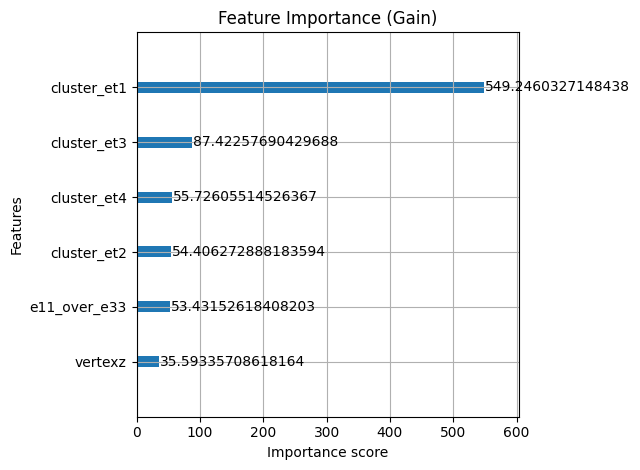

In [71]:
# Make predictions
y_pred = model.predict(X_test)

# Print evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance plot
plt.figure(figsize=(8, 6))
xgb.plot_importance(model, importance_type='gain')
plt.title("Feature Importance (Gain)")
plt.tight_layout()
plt.show()

## 8. BDT Score Analysis


--- BDT score summary ---
 Signal:   n= 259033   mean=0.900   min=0.002   max=0.996
 Bkgd:     n=  62329   mean=0.412   min=0.000   max=0.994


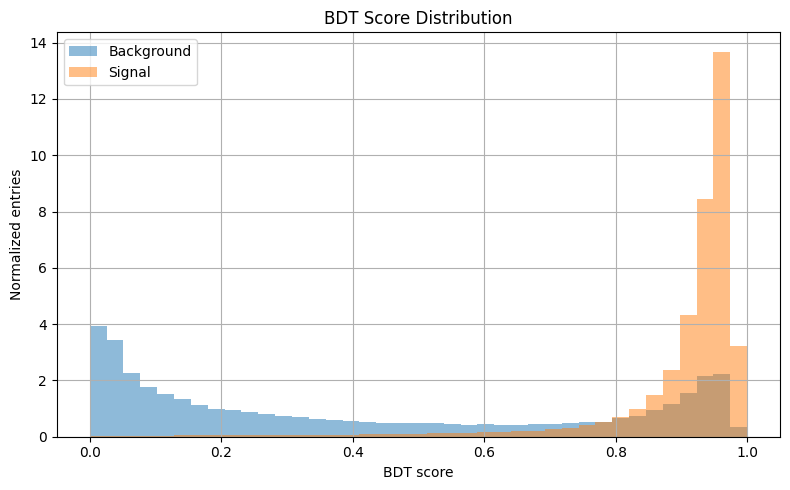

In [65]:
# Generate BDT scores for the full dataset
df["bdt_score"] = model.predict_proba(df[features])[:, 1]

# 1. Continuous BDT scores (probability for class 1) on test set
score_test = model.predict_proba(X_test)[:, 1]

# 2. Split by truth label
sig_mask = y_test == 1
bkg_mask = y_test == 0

sig_scores = score_test[sig_mask]
bkg_scores = score_test[bkg_mask]

# 3. Quick numerical summary
print("\n--- BDT score summary ---")
print(f" Signal:   n={sig_scores.size:7d}   mean={sig_scores.mean():.3f}   "
      f"min={sig_scores.min():.3f}   max={sig_scores.max():.3f}")
print(f" Bkgd:     n={bkg_scores.size:7d}   mean={bkg_scores.mean():.3f}   "
      f"min={bkg_scores.min():.3f}   max={bkg_scores.max():.3f}")

# 4. Overlaid histograms
bins = np.linspace(0, 1, 40)  # 0–1 probability range

plt.figure(figsize=(8, 5))
plt.hist(bkg_scores, bins=bins, alpha=0.5, label="Background", density=True)
plt.hist(sig_scores, bins=bins, alpha=0.5, label="Signal", density=True)
plt.xlabel("BDT score")
plt.ylabel("Normalized entries")
plt.title("BDT Score Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

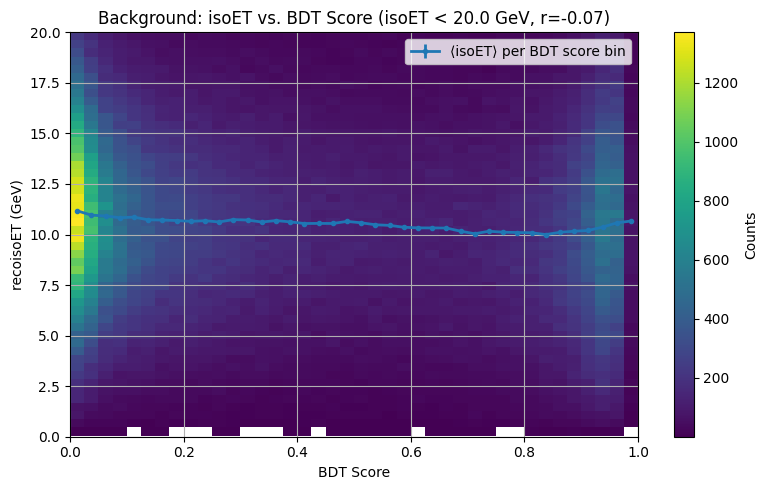

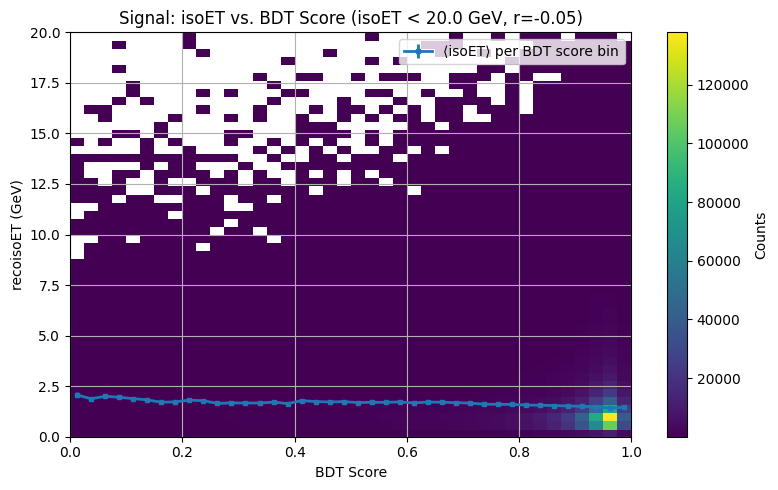

\nCorrelation coefficients:
Background: BDT score vs. isoET = -0.070
Signal: BDT score vs. isoET = -0.050


In [64]:
# BDT Score vs. Isolation ET Analysis (with BDT score on x-axis)
import numpy as np
import matplotlib.pyplot as plt

# --- pull arrays ---
mask_bg  = df["label"] == 0
mask_sig = df["label"] == 1

score_bg = df.loc[mask_bg,  "bdt_score"].values
score_sig= df.loc[mask_sig, "bdt_score"].values
iso_bg   = df.loc[mask_bg,  "recoisoET"].values
iso_sig  = df.loc[mask_sig, "recoisoET"].values

w_bg  = df.loc[mask_bg,  "weight"].values if "weight" in df else np.ones_like(score_bg)
w_sig = df.loc[mask_sig, "weight"].values if "weight" in df else np.ones_like(score_sig)

# --- helper functions ---
def weighted_profile_with_err(x, y, w, edges):
    """Calculate weighted mean of y in x-bins with error bars."""
    centers = 0.5*(edges[:-1] + edges[1:])
    mean = np.full_like(centers, np.nan, dtype=float)
    sem  = np.full_like(centers, np.nan, dtype=float)
    idx = np.digitize(x, edges) - 1
    valid = (idx >= 0) & (idx < len(centers))
    
    for b in range(len(centers)):
        m = valid & (idx == b)
        if not np.any(m): 
            continue
        W  = w[m].sum()
        if W <= 0: 
            continue
        mu = np.sum(w[m]*y[m]) / W
        mean[b] = mu
        sum_w2  = np.sum(w[m]**2)
        var_num = np.sum(w[m]*(y[m]-mu)**2)
        neff = (W**2) / sum_w2 if sum_w2 > 0 else np.nan
        if np.isfinite(neff) and neff > 0:
            var = var_num / W
            sem[b] = np.sqrt(var / neff)
    return centers, mean, sem

def wpearson(x, y, w):
    """Weighted Pearson correlation."""
    mx = np.average(x, weights=w); my = np.average(y, weights=w)
    vx = np.average((x-mx)**2, weights=w); vy = np.average((y-my)**2, weights=w)
    if vx <= 0 or vy <= 0: 
        return np.nan
    cov = np.average((x-mx)*(y-my), weights=w)
    return cov / np.sqrt(vx*vy)

# --- apply isoET < 20 cut & set edges ---
cut_max = 20.0
def cut_under(x, y, w, ymax):
    """Filter data where y < ymax."""
    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(w) & (y < ymax)
    return x[m], y[m], w[m]

score_bg_c, iso_bg_c, w_bg_c   = cut_under(score_bg, iso_bg, w_bg, cut_max)
score_sig_c, iso_sig_c, w_sig_c = cut_under(score_sig, iso_sig, w_sig, cut_max)

# Set up BDT score bins (x-axis)
score_edges = np.linspace(0.0, 1.0, 41)

# --- profiles & correlations on cut sample ---
c_bg,  m_bg,  se_bg  = weighted_profile_with_err(score_bg_c, iso_bg_c, w_bg_c, score_edges)
c_sig, m_sig, se_sig = weighted_profile_with_err(score_sig_c, iso_sig_c, w_sig_c, score_edges)
r_bg  = wpearson(score_bg_c, iso_bg_c, w_bg_c)
r_sig = wpearson(score_sig_c, iso_sig_c, w_sig_c)

# =========================
# Plot 1: Background only
# =========================
fig1, ax1 = plt.subplots(figsize=(8, 5))
hb = ax1.hist2d(score_bg_c, iso_bg_c, bins=(score_edges, 50), cmin=1)
fig1.colorbar(hb[3], ax=ax1, label="Counts")
ax1.errorbar(c_bg, m_bg, yerr=se_bg, fmt='o-', lw=2, ms=3, label="⟨isoET⟩ per BDT score bin")
ax1.set(xlim=(0, 1), ylim=(0, cut_max),
        xlabel="BDT Score", ylabel="recoisoET (GeV)",
        title=f"Background: isoET vs. BDT Score (isoET < {cut_max} GeV, r={r_bg:.2f})")
ax1.grid(True); ax1.legend()
plt.tight_layout()

# ======================
# Plot 2: Signal only
# ======================
fig2, ax2 = plt.subplots(figsize=(8, 5))
hb = ax2.hist2d(score_sig_c, iso_sig_c, bins=(score_edges, 50), cmin=1)
fig2.colorbar(hb[3], ax=ax2, label="Counts")
ax2.errorbar(c_sig, m_sig, yerr=se_sig, fmt='s-', lw=2, ms=3, label="⟨isoET⟩ per BDT score bin")
ax2.set(xlim=(0, 1), ylim=(0, cut_max),
        xlabel="BDT Score", ylabel="recoisoET (GeV)",
        title=f"Signal: isoET vs. BDT Score (isoET < {cut_max} GeV, r={r_sig:.2f})")
ax2.grid(True); ax2.legend()
plt.tight_layout()

plt.show()

print(f"\\nCorrelation coefficients:")
print(f"Background: BDT score vs. isoET = {r_bg:.3f}")
print(f"Signal: BDT score vs. isoET = {r_sig:.3f}")

## 9. Save Trained Model

In [ ]:
# Save model in JSON format
model.save_model("bdt_model.json")
print("Model saved as bdt_model.json")

# Save in ROOT format for TMVA compatibility
try:
    # Update feature names to generic format for ROOT
    booster.feature_names = [f"f{i}" for i in range(len(features))]
    ROOT.TMVA.Experimental.SaveXGBoost(model, "myBDT", "bdt_model.root", num_inputs=len(features))
    print("Model saved as bdt_model.root for TMVA")
except Exception as e:
    print(f"ROOT export failed: {e}")
    print("Model saved in JSON format only")

## Model Training Complete

The BDT model has been successfully trained and saved. Key results:
- Features used: vertex z-position and cluster energy ratios
- Applied kinematic reweighting for Et and Eta distributions
- Model saved in both JSON and ROOT formats

The trained model can now be used for photon identification in physics analysis.

## Vertex-Binned BDT Training (Optional)

Alternative training approach: Train separate BDT models for different vertex z ranges to account for vertex-dependent detector response variations.

In [72]:
# =============================================================================
# CENTRALIZED BINNING CONFIGURATION
# =============================================================================
# Define ALL vertex z and eta bins in ONE place for consistency

# Enable vertex-binned training (set to True to activate)
ENABLE_VERTEX_BINNING = True

# =============================================================================
# VERTEX Z BINS (defined ONLY here)
# =============================================================================
vertex_z_bins = [
    (-30, -10, "Forward"),   # Forward region
    (-10, 10, "Central"),    # Central region  
    (10, 30, "Backward")     # Backward region
]

# =============================================================================
# CLUSTER ETA BINS (defined ONLY here)  
# =============================================================================
cluster_eta_bins = [
    (-0.7, 0.7, "Central"),    # Central eta region
    # Add more bins if needed:
    # (-0.7, -0.2, "Negative"),  # Negative eta region
    # (0.2, 0.7, "Positive")     # Positive eta region
]

print("=== CENTRALIZED BINNING CONFIGURATION ===")
print(f"Vertex Z bins defined: {len(vertex_z_bins)}")
for vz_min, vz_max, vz_label in vertex_z_bins:
    print(f"  {vz_label}: [{vz_min:+.0f}, {vz_max:+.0f}] cm")

print(f"Cluster Eta bins defined: {len(cluster_eta_bins)}")
for eta_min, eta_max, eta_label in cluster_eta_bins:
    print(f"  {eta_label}: [{eta_min:+.1f}, {eta_max:+.1f}]")

print(f"Total combined bins will be: {len(vertex_z_bins) * len(cluster_eta_bins)}")
print("All subsequent analysis will use these centralized bin definitions.")

# =============================================================================
# VERTEX-BINNED BDT TRAINING SETUP
# =============================================================================
if ENABLE_VERTEX_BINNING:
    print("\n=== VERTEX & ETA BINNED BDT TRAINING ===")
    
    # Generate combined bins (vertex z × eta) using the centralized definitions
    combined_bins = []
    for vz_min, vz_max, vz_label in vertex_z_bins:
        for eta_min, eta_max, eta_label in cluster_eta_bins:
            bin_name = f"{vz_label}_{eta_label}"
            combined_bins.append({
                'name': bin_name,
                'vz_range': (vz_min, vz_max),
                'eta_range': (eta_min, eta_max),
                'vz_label': vz_label,
                'eta_label': eta_label
            })
    
    print(f"Training {len(combined_bins)} separate BDT models for combined vertex-eta regions:")
    print(f"Vertex Z regions: {len(vertex_z_bins)} bins")
    print(f"Cluster Eta regions: {len(cluster_eta_bins)} bins")
    print(f"Total combined regions: {len(combined_bins)} bins")
    print()
    
    # Display the binning scheme
    print("Combined binning scheme:")
    print(f"{'Bin Name':<20} {'Vertex Z Range':<15} {'Eta Range':<12} {'Description'}")
    print("-" * 70)
    for bin_info in combined_bins:
        vz_min, vz_max = bin_info['vz_range']
        eta_min, eta_max = bin_info['eta_range']
        description = f"{bin_info['vz_label']} VZ, {bin_info['eta_label']} Eta"
        print(f"{bin_info['name']:<20} [{vz_min:+.0f}, {vz_max:+.0f}] cm     [{eta_min:+.1f}, {eta_max:+.1f}]      {description}")
    
    print()
    
    # Storage for combined binned models and results
    vertex_models = {}

=== VERTEX & ETA BINNED BDT TRAINING ===
Training 3 separate BDT models for combined vertex-eta regions:
Vertex Z regions: 3 bins
Cluster Eta regions: 1 bins
Total combined regions: 3 bins

Combined binning scheme:
Bin Name             Vertex Z Range  Eta Range    Description
----------------------------------------------------------------------
Forward_Central      [-30, -10] cm     [-0.7, +0.7]      Forward VZ, Central Eta
Central_Central      [-10, +10] cm     [-0.7, +0.7]      Central VZ, Central Eta
Backward_Central     [+10, +30] cm     [-0.7, +0.7]      Backward VZ, Central Eta



### 📝 **IMPORTANT: Centralized Bin Configuration**

**All vertex z and eta bins are now defined in ONE place above!** ☝️

To modify the binning scheme:
1. **Edit `vertex_z_bins`** to change vertex z regions
2. **Edit `cluster_eta_bins`** to change eta regions  
3. **All subsequent analysis** will automatically use your new definitions

**Current Configuration:**
- **Vertex Z bins**: Forward, Central, Backward regions
- **Cluster Eta bins**: Central region only  
- **Total combinations**: 3×1 = 3 models will be trained

**No need to modify any other cells!** The rest of the notebook automatically references these centralized definitions.

In [73]:
# Train BDT models for each combined vertex-eta bin
if ENABLE_VERTEX_BINNING:
    
    for bin_idx, bin_info in enumerate(combined_bins):
        bin_name = bin_info['name']
        vz_min, vz_max = bin_info['vz_range']
        eta_min, eta_max = bin_info['eta_range']
        vz_label = bin_info['vz_label']
        eta_label = bin_info['eta_label']
        
        print(f"\n--- Training BDT for {bin_name} bin ---")
        print(f"    Vertex Z: {vz_min} < vertexz < {vz_max} cm ({vz_label})")
        print(f"    Cluster Eta: {eta_min} < cluster_Eta < {eta_max} ({eta_label})")
        
        # Filter data for this combined vertex-eta bin
        combined_mask = ((df_weighted["vertexz"] >= vz_min) & (df_weighted["vertexz"] < vz_max) &
                        (df_weighted["cluster_Eta"] >= eta_min) & (df_weighted["cluster_Eta"] < eta_max))
        df_combined_bin = df_weighted.loc[combined_mask].copy()
        
        if len(df_combined_bin) < 100:  # Minimum sample requirement
            print(f"  Insufficient data for {bin_name}: {len(df_combined_bin)} samples. Skipping.")
            vertex_models[bin_name] = None
            vertex_results[bin_name] = None
            continue
        
        print(f"  Samples in {bin_name}: {len(df_combined_bin)}")
        print(f"    Signal: {np.sum(df_combined_bin['label'] == 1)}")
        print(f"    Background: {np.sum(df_combined_bin['label'] == 0)}")
        
        # Prepare training data for this combined bin
        X_combined = df_combined_bin[features].to_numpy(dtype=np.float32)
        y_combined = df_combined_bin["label"].to_numpy(dtype=np.int32)
        w_combined = df_combined_bin["weight"].to_numpy(dtype=np.float32)
        
        # Train/test split for this combined bin
        from sklearn.model_selection import train_test_split
        X_train_c, X_test_c, y_train_c, y_test_c, w_train_c, w_test_c = train_test_split(
            X_combined, y_combined, w_combined, test_size=0.2, random_state=42, 
            stratify=y_combined if len(np.unique(y_combined)) > 1 else None
        )
        
        # Check if we have both classes in training set
        unique_labels = np.unique(y_train_c)
        if len(unique_labels) < 2:
            print(f"  Only one class in training set for {bin_name}. Skipping.")
            vertex_models[bin_name] = None
            vertex_results[bin_name] = None
            continue
        
        # Configure and train XGBoost model for this combined bin
        model_combined = xgb.XGBClassifier(
            max_depth=5,
            n_estimators=1000,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=1,
            reg_alpha=1,
            reg_lambda=1,
            eval_metric='auc',
            random_state=42
        )
        
        print(f"  Training XGBoost model for {bin_name}...")
        model_combined.fit(X_train_c, y_train_c, sample_weight=w_train_c)
        
        # Set feature names
        booster_combined = model_combined.get_booster()
        booster_combined.feature_names = features
        
        # Make predictions on test set
        y_pred_c = model_combined.predict(X_test_c)
        y_score_c = model_combined.predict_proba(X_test_c)[:, 1]
        
        # Calculate AUC for this combined bin
        try:
            auc_combined = roc_auc_score(y_test_c, y_score_c, sample_weight=w_test_c)
            print(f"  AUC for {bin_name}: {auc_combined:.3f}")
        except Exception as e:
            print(f"  Could not calculate AUC for {bin_name}: {e}")
            auc_combined = np.nan
        
        # Store model and results
        vertex_models[bin_name] = model_combined
        vertex_results[bin_name] = {
            'model': model_combined,
            'auc': auc_combined,
            'X_test': X_test_c,
            'y_test': y_test_c,
            'y_score': y_score_c,
            'w_test': w_test_c,
            'vertex_range': (vz_min, vz_max),
            'eta_range': (eta_min, eta_max),
            'combined_range': {'vz': (vz_min, vz_max), 'eta': (eta_min, eta_max)},
            'bin_info': bin_info,  # Store complete bin information
            'n_samples': len(df_combined_bin),
            'n_train': len(X_train_c),
            'n_test': len(X_test_c)
        }
        
        print(f"  {bin_name} model training completed!")
    
    print("\n=== COMBINED VERTEX-ETA BINNED TRAINING SUMMARY ===")
    print(f"{'Bin Name':<20} {'AUC':<8} {'Test Samples':<12} {'VZ Range':<12} {'Eta Range'}")
    print("-" * 75)
    
    successful_models = 0
    total_test_samples = 0
    
    for bin_name, result in vertex_results.items():
        if result is not None:
            vz_min, vz_max = result['vertex_range']
            eta_min, eta_max = result['eta_range']
            vz_range_str = f"[{vz_min:+.0f},{vz_max:+.0f}]"
            eta_range_str = f"[{eta_min:+.1f},{eta_max:+.1f}]"
            print(f"{bin_name:<20} {result['auc']:<8.3f} {result['n_test']:<12,} {vz_range_str:<12} {eta_range_str}")
            successful_models += 1
            total_test_samples += result['n_test']
        else:
            print(f"{bin_name:<20} {'Skipped':<8} {'(insufficient data)'}")
    
    print(f"\nSUMMARY: {successful_models}/{len(combined_bins)} models trained successfully")
    print(f"Total test samples across all bins: {total_test_samples:,}")

else:
    print("Combined vertex-eta binned training skipped.")


--- Training BDT for Forward_Central bin ---
    Vertex Z: -30 < vertexz < -10 cm (Forward)
    Cluster Eta: -0.7 < cluster_Eta < 0.7 (Central)


  Samples in Forward_Central: 525308
    Signal: 424404
    Background: 100904
  Training XGBoost model for Forward_Central...
  Training XGBoost model for Forward_Central...
  AUC for Forward_Central: 0.865
  Forward_Central model training completed!

--- Training BDT for Central_Central bin ---
    Vertex Z: -10 < vertexz < 10 cm (Central)
    Cluster Eta: -0.7 < cluster_Eta < 0.7 (Central)
  AUC for Forward_Central: 0.865
  Forward_Central model training completed!

--- Training BDT for Central_Central bin ---
    Vertex Z: -10 < vertexz < 10 cm (Central)
    Cluster Eta: -0.7 < cluster_Eta < 0.7 (Central)
  Samples in Central_Central: 552953
    Signal: 444361
    Background: 108592
  Samples in Central_Central: 552953
    Signal: 444361
    Background: 108592
  Training XGBoost model for Central_Central...
  Training XGBoost model for Central_Central...
  AUC for Central_Central: 0.889
  Central_Central model training completed!

--- Training BDT for Backward_Central bin ---
    V


=== BDT SCORE DISTRIBUTIONS BY BIN ===
Creating BDT score distribution plots for signal and background in each vertex-eta bin...


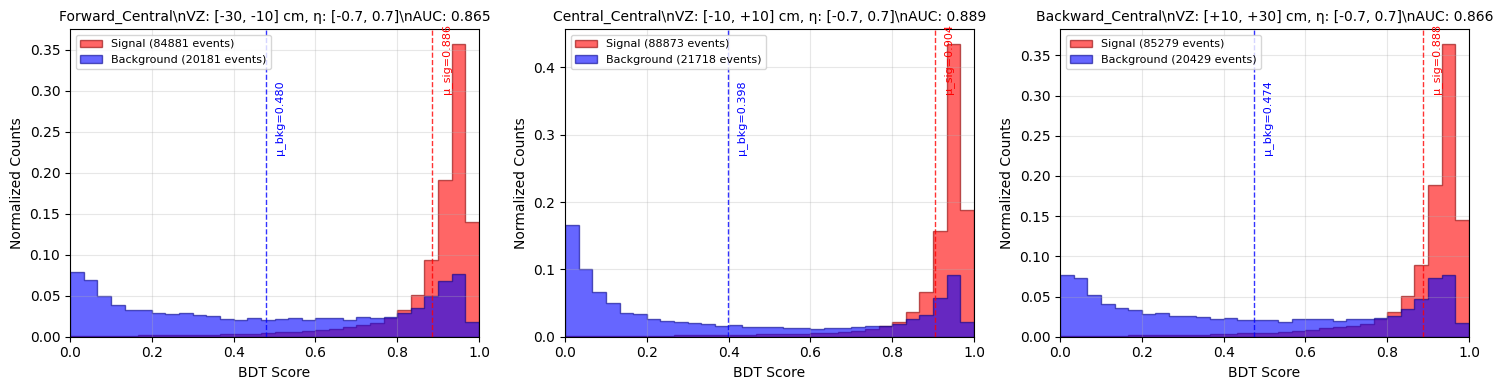


=== BDT SCORE DISTRIBUTION SUMMARY ===
Bin Name             Signal μ   Bkg μ      Separation   AUC     
-----------------------------------------------------------------
Forward_Central      0.886      0.480      +0.407       0.865   
Central_Central      0.904      0.398      +0.506       0.889   
Backward_Central     0.888      0.474      +0.413       0.866   

BDT score distribution analysis complete!
• Red histograms show signal BDT score distributions
• Blue histograms show background BDT score distributions
• Dashed vertical lines show weighted mean scores
• Higher separation (μ_sig - μ_bkg) indicates better discrimination
• All histograms are normalized to unity for comparison


In [74]:
# BDT Score Distributions for Signal and Background in Each Bin
if ENABLE_VERTEX_BINNING and vertex_models and any(model is not None for model in vertex_models.values()):
    print("\n=== BDT SCORE DISTRIBUTIONS BY BIN ===")
    print("Creating BDT score distribution plots for signal and background in each vertex-eta bin...")
    
    # Count successful models for subplot layout
    valid_models = [(bin_name, result) for bin_name, result in vertex_results.items() if result is not None]
    n_models = len(valid_models)
    
    if n_models > 0:
        # Create subplot layout
        n_cols = min(3, n_models)  # Maximum 3 columns
        n_rows = (n_models + n_cols - 1) // n_cols  # Ceiling division
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_models == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        axes_flat = axes.flatten() if n_models > 1 else axes
        
        # BDT score range for consistent plotting
        score_edges = np.linspace(0, 1, 31)  # 30 bins from 0 to 1
        
        for i, (bin_name, result) in enumerate(valid_models):
            ax = axes_flat[i]
            
            # Get test data and predictions for this bin
            y_test_bin = result['y_test']
            y_score_bin = result['y_score']
            w_test_bin = result['w_test']
            
            # Separate signal and background
            sig_mask = y_test_bin == 1
            bkg_mask = y_test_bin == 0
            
            # Calculate scores for signal and background
            scores_sig = y_score_bin[sig_mask]
            scores_bkg = y_score_bin[bkg_mask]
            weights_sig = w_test_bin[sig_mask]
            weights_bkg = w_test_bin[bkg_mask]
            
            # Create histograms
            hist_sig, _ = np.histogram(scores_sig, bins=score_edges, weights=weights_sig)
            hist_bkg, _ = np.histogram(scores_bkg, bins=score_edges, weights=weights_bkg)
            
            # Normalize to unity for better comparison
            hist_sig_norm = hist_sig / np.sum(hist_sig) if np.sum(hist_sig) > 0 else hist_sig
            hist_bkg_norm = hist_bkg / np.sum(hist_bkg) if np.sum(hist_bkg) > 0 else hist_bkg
            
            # Plot bin centers
            score_centers = (score_edges[:-1] + score_edges[1:]) / 2
            
            # Plot histograms
            ax.hist(score_centers, bins=score_edges, weights=hist_sig_norm, 
                   alpha=0.6, color='red', label=f'Signal ({np.sum(sig_mask)} events)',
                   histtype='stepfilled', edgecolor='darkred')
            
            ax.hist(score_centers, bins=score_edges, weights=hist_bkg_norm,
                   alpha=0.6, color='blue', label=f'Background ({np.sum(bkg_mask)} events)', 
                   histtype='stepfilled', edgecolor='darkblue')
            
            # Get bin information for title
            vz_min, vz_max = result['vertex_range']
            eta_min, eta_max = result['eta_range']
            auc_bin = result['auc']
            
            # Calculate separation metrics
            sig_mean = np.average(scores_sig, weights=weights_sig) if len(scores_sig) > 0 else 0
            bkg_mean = np.average(scores_bkg, weights=weights_bkg) if len(scores_bkg) > 0 else 0
            
            # Set title and labels
            ax.set_title(f'{bin_name}\\nVZ: [{vz_min:+.0f}, {vz_max:+.0f}] cm, η: [{eta_min:.1f}, {eta_max:.1f}]\\nAUC: {auc_bin:.3f}',
                        fontsize=10)
            ax.set_xlabel('BDT Score')
            ax.set_ylabel('Normalized Counts')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, 1)
            
            # Add mean score lines
            if len(scores_sig) > 0:
                ax.axvline(sig_mean, color='red', linestyle='--', alpha=0.8, linewidth=1)
                ax.text(sig_mean + 0.02, ax.get_ylim()[1] * 0.8, f'μ_sig={sig_mean:.3f}', 
                       rotation=90, color='red', fontsize=8)
            
            if len(scores_bkg) > 0:
                ax.axvline(bkg_mean, color='blue', linestyle='--', alpha=0.8, linewidth=1)
                ax.text(bkg_mean + 0.02, ax.get_ylim()[1] * 0.6, f'μ_bkg={bkg_mean:.3f}', 
                       rotation=90, color='blue', fontsize=8)
        
        # Hide unused subplots
        for j in range(n_models, len(axes_flat)):
            axes_flat[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print(f"\n=== BDT SCORE DISTRIBUTION SUMMARY ===")
        print(f"{'Bin Name':<20} {'Signal μ':<10} {'Bkg μ':<10} {'Separation':<12} {'AUC':<8}")
        print("-" * 65)
        
        for bin_name, result in valid_models:
            y_test_bin = result['y_test']
            y_score_bin = result['y_score']
            w_test_bin = result['w_test']
            
            sig_mask = y_test_bin == 1
            bkg_mask = y_test_bin == 0
            
            if np.sum(sig_mask) > 0 and np.sum(bkg_mask) > 0:
                scores_sig = y_score_bin[sig_mask]
                scores_bkg = y_score_bin[bkg_mask]
                weights_sig = w_test_bin[sig_mask]
                weights_bkg = w_test_bin[bkg_mask]
                
                sig_mean = np.average(scores_sig, weights=weights_sig)
                bkg_mean = np.average(scores_bkg, weights=weights_bkg)
                separation = sig_mean - bkg_mean
                
                print(f"{bin_name:<20} {sig_mean:<10.3f} {bkg_mean:<10.3f} {separation:<+12.3f} {result['auc']:<8.3f}")
            else:
                print(f"{bin_name:<20} {'N/A':<10} {'N/A':<10} {'N/A':<12} {result['auc']:<8.3f}")
        
        print("\nBDT score distribution analysis complete!")
        print("• Red histograms show signal BDT score distributions")
        print("• Blue histograms show background BDT score distributions")
        print("• Dashed vertical lines show weighted mean scores")
        print("• Higher separation (μ_sig - μ_bkg) indicates better discrimination")
        print("• All histograms are normalized to unity for comparison")
        
    else:
        print("No valid models found for BDT score distribution analysis.")

else:
    print("BDT score distribution analysis skipped (vertex binning disabled or no models).")


=== INCLUSIVE vs COMBINED VERTEX-ETA BINNED PERFORMANCE COMPARISON ===
Calculating inclusive AUC using single model...


Inclusive AUC (single model): 0.881

Calculating combined vertex-eta binned inclusive performance...
  Forward_Central   : Combined AUC = 0.874, Inclusive AUC = 0.869, Δ = +0.005 (105130 events)
                        VZ[-30,-10], η[-0.7,+0.7]
  Forward_Central   : Combined AUC = 0.874, Inclusive AUC = 0.869, Δ = +0.005 (105130 events)
                        VZ[-30,-10], η[-0.7,+0.7]
  Central_Central   : Combined AUC = 0.905, Inclusive AUC = 0.897, Δ = +0.008 (110521 events)
                        VZ[-10,+10], η[-0.7,+0.7]
  Central_Central   : Combined AUC = 0.905, Inclusive AUC = 0.897, Δ = +0.008 (110521 events)
                        VZ[-10,+10], η[-0.7,+0.7]
  Backward_Central  : Combined AUC = 0.880, Inclusive AUC = 0.874, Δ = +0.006 (105709 events)
                        VZ[+10,+30], η[-0.7,+0.7]

Inclusive AUC (vertex-binned models): 0.887
Performance improvement: +0.007
  Backward_Central  : Combined AUC = 0.880, Inclusive AUC = 0.874, Δ = +0.006 (105709 events)
        

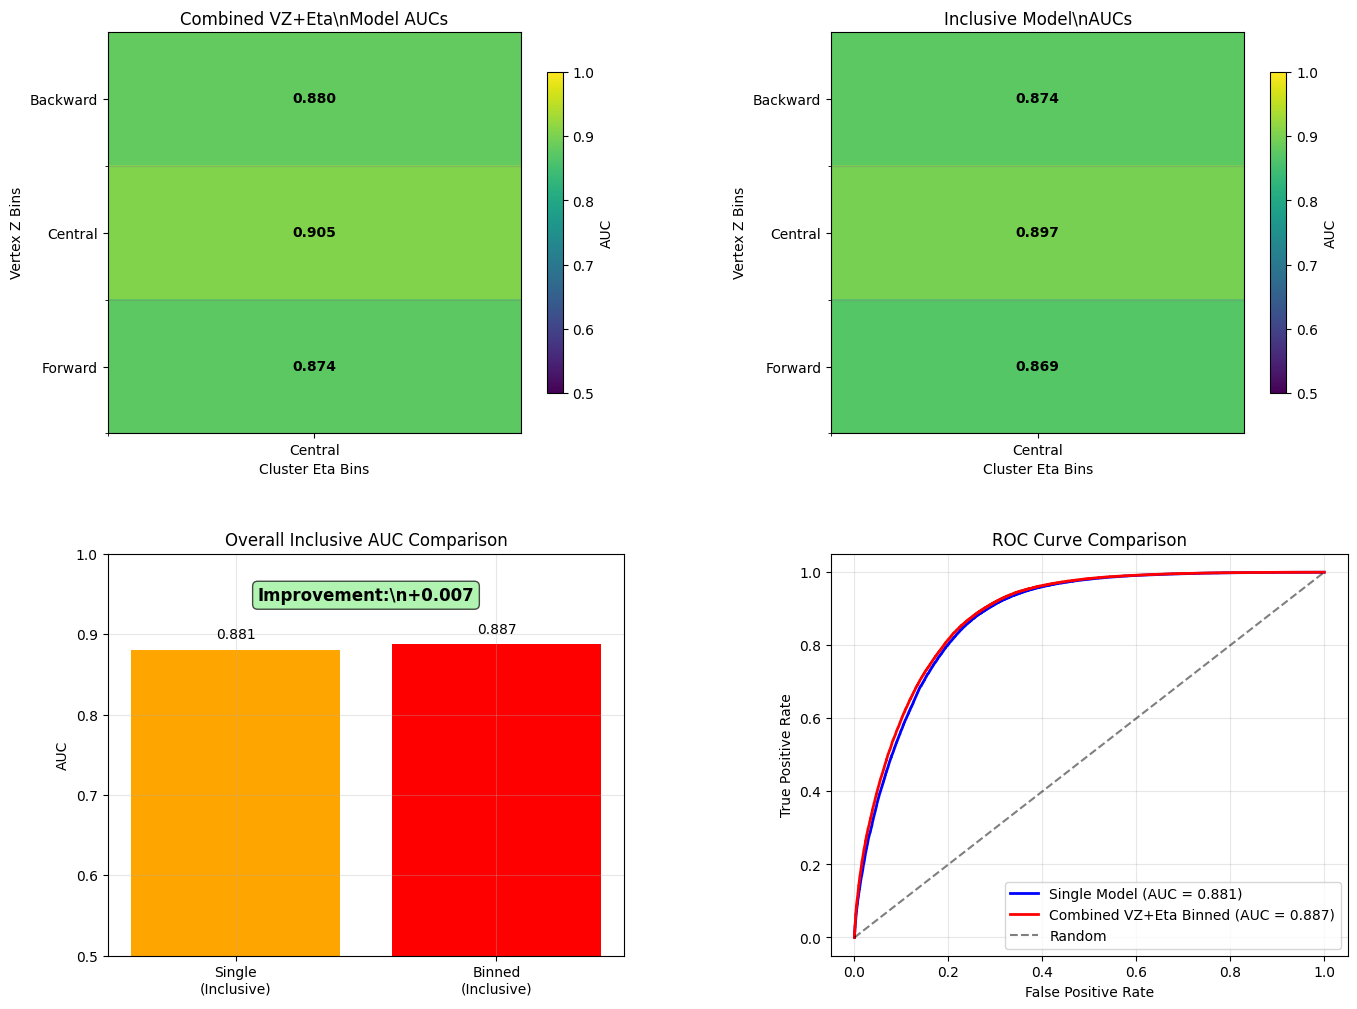


=== DETAILED PERFORMANCE SUMMARY ===
Single inclusive model AUC:              0.881
Combined vertex-eta binned AUC:          0.887
Overall improvement:                     +0.007
Relative improvement:                    +0.8%

=== PER-BIN PERFORMANCE COMPARISON ===
Combined Bin         VZ+Eta Binned   Inclusive    Improvement  Events  
---------------------------------------------------------------------------
Forward_Central      0.874           0.869        0.005        105130  
Central_Central      0.905           0.897        0.008        110521  
Backward_Central     0.880           0.874        0.006        105709  
Average                                           0.007       
Weighted Avg                                      0.007       

Best improvement:  Central_Central (+0.008)
Worst improvement: Forward_Central (+0.005)

=== COMBINED BINNING STRATEGY ANALYSIS ===
Vertex Z bins used: 3
Cluster Eta bins used: 1
Total combined bins: 3
Successfully trained models: 3
Coverage:

In [75]:
# Calculate Inclusive AUC and Compare with Combined Vertex-Eta Binned Approach
if ENABLE_VERTEX_BINNING and any(result is not None for result in vertex_results.values()):
    
    print("\n=== INCLUSIVE vs COMBINED VERTEX-ETA BINNED PERFORMANCE COMPARISON ===")
    
    # Calculate inclusive AUC using the original single model
    print("Calculating inclusive AUC using single model...")
    df_test_inclusive = df_weighted.sample(frac=0.2, random_state=42)  # Same test split
    X_test_inclusive = df_test_inclusive[features].to_numpy(dtype=np.float32)
    y_test_inclusive = df_test_inclusive["label"].to_numpy(dtype=np.int32)
    w_test_inclusive = df_test_inclusive["weight"].to_numpy(dtype=np.float32)
    
    # Get predictions from single inclusive model
    y_score_inclusive = model.predict_proba(X_test_inclusive)[:, 1]
    auc_inclusive_single = roc_auc_score(y_test_inclusive, y_score_inclusive, sample_weight=w_test_inclusive)
    
    print(f"Inclusive AUC (single model): {auc_inclusive_single:.3f}")
    
    # Calculate combined vertex-eta binned inclusive performance
    print("\nCalculating combined vertex-eta binned inclusive performance...")
    
    # Collect predictions from combined vertex-eta binned models and compare with inclusive model
    all_predictions_binned = []
    all_true_labels = []
    all_weights = []
    vertex_bin_aucs = []
    inclusive_bin_aucs = []  # Store inclusive model performance in each bin
    
    for bin_name, result in vertex_results.items():
        if result is not None:
            # Apply combined vertex-eta specific model to test data in that range
            vz_min, vz_max = result['vertex_range']
            eta_min, eta_max = result['eta_range']
            
            # Create combined mask for both vertex and eta ranges
            combined_mask = ((df_test_inclusive["vertexz"] >= vz_min) & (df_test_inclusive["vertexz"] < vz_max) &
                           (df_test_inclusive["cluster_Eta"] >= eta_min) & (df_test_inclusive["cluster_Eta"] < eta_max))
            
            if np.sum(combined_mask) > 0:
                X_combined_test = X_test_inclusive[combined_mask]
                y_combined_test = y_test_inclusive[combined_mask]
                w_combined_test = w_test_inclusive[combined_mask]
                
                if len(X_combined_test) > 0:
                    # Get predictions from combined vertex-eta specific model
                    y_score_combined = result['model'].predict_proba(X_combined_test)[:, 1]
                    
                    # Get predictions from inclusive model for same data
                    y_score_inclusive_bin = model.predict_proba(X_combined_test)[:, 1]
                    
                    # Store combined binned predictions for inclusive calculation
                    all_predictions_binned.extend(y_score_combined)
                    all_true_labels.extend(y_combined_test)
                    all_weights.extend(w_combined_test)
                    
                    # Calculate AUC for both models in this combined bin
                    if len(np.unique(y_combined_test)) > 1:
                        # Combined bin specific model AUC
                        auc_combined_bin = roc_auc_score(y_combined_test, y_score_combined, sample_weight=w_combined_test)
                        vertex_bin_aucs.append((bin_name, auc_combined_bin, len(y_combined_test)))
                        
                        # Inclusive model AUC in this bin
                        auc_inclusive_bin = roc_auc_score(y_combined_test, y_score_inclusive_bin, sample_weight=w_combined_test)
                        inclusive_bin_aucs.append((bin_name, auc_inclusive_bin, len(y_combined_test)))
                        
                        improvement = auc_combined_bin - auc_inclusive_bin
                        vz_range_str = f"VZ[{vz_min:+.0f},{vz_max:+.0f}]"
                        eta_range_str = f"η[{eta_min:+.1f},{eta_max:+.1f}]"
                        print(f"  {bin_name:<18s}: Combined AUC = {auc_combined_bin:.3f}, Inclusive AUC = {auc_inclusive_bin:.3f}, Δ = {improvement:+.3f} ({len(y_combined_test)} events)")
                        print(f"  {'':20s}  {vz_range_str}, {eta_range_str}")
    
    # Calculate inclusive AUC from combined vertex-eta binned predictions
    if len(all_predictions_binned) > 0:
        all_predictions_binned = np.array(all_predictions_binned)
        all_true_labels = np.array(all_true_labels)
        all_weights = np.array(all_weights)
        
        auc_inclusive_binned = roc_auc_score(all_true_labels, all_predictions_binned, sample_weight=all_weights)
        print(f"\nInclusive AUC (vertex-binned models): {auc_inclusive_binned:.3f}")
        print(f"Performance improvement: {auc_inclusive_binned - auc_inclusive_single:+.3f}")
        
        # Create enhanced comparison plot with 2x2 layout
        fig = plt.figure(figsize=(16, 12))
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.4)
        ax1a = fig.add_subplot(gs[0, 0])  # Top-left: Combined model
        ax1b = fig.add_subplot(gs[0, 1])  # Top-right: Inclusive model
        ax2 = fig.add_subplot(gs[1, 0])   # Bottom-left: Overall comparison
        ax3 = fig.add_subplot(gs[1, 1])   # Bottom-right: ROC curves
        
        # Extract bin information and create 2D AUC matrices
        vertex_z_labels = [label for (_, _, label) in vertex_z_bins]
        cluster_eta_labels = [label for (_, _, label) in cluster_eta_bins]
        
        # Initialize matrices for AUC values
        auc_matrix_combined = np.full((len(vertex_z_labels), len(cluster_eta_labels)), np.nan)
        auc_matrix_inclusive = np.full((len(vertex_z_labels), len(cluster_eta_labels)), np.nan)
        
        # Fill matrices with AUC data
        for (bin_name_v, auc_v, n_v), (bin_name_i, auc_i, n_i) in zip(vertex_bin_aucs, inclusive_bin_aucs):
            # Parse bin name to get vertex and eta indices
            vz_label, eta_label = bin_name_v.split('_', 1)
            
            try:
                vz_idx = vertex_z_labels.index(vz_label)
                eta_idx = cluster_eta_labels.index(eta_label)
                
                auc_matrix_combined[vz_idx, eta_idx] = auc_v
                auc_matrix_inclusive[vz_idx, eta_idx] = auc_i
            except (ValueError, IndexError) as e:
                print(f"Warning: Could not parse bin {bin_name_v}: {e}")
                continue
        
        # Plot 1a: Combined VZ+Eta Model AUCs
        im1 = ax1a.imshow(auc_matrix_combined, cmap='viridis', aspect='auto', 
                         vmin=0.5, vmax=1.0, origin='lower')
        
        # Add colorbar for combined model
        cbar1 = fig.colorbar(im1, ax=ax1a, shrink=0.8)
        cbar1.set_label('AUC')
        
        # Set ticks and labels for combined model
        ax1a.set_xticks(range(len(cluster_eta_labels)))
        ax1a.set_yticks(range(len(vertex_z_labels)))
        ax1a.set_xticklabels(cluster_eta_labels)
        ax1a.set_yticklabels(vertex_z_labels)
        ax1a.set_xlabel('Cluster Eta Bins')
        ax1a.set_ylabel('Vertex Z Bins')
        ax1a.set_title('Combined VZ+Eta\\nModel AUCs')
        
        # Add text annotations for combined model
        for i in range(len(vertex_z_labels)):
            for j in range(len(cluster_eta_labels)):
                if np.isfinite(auc_matrix_combined[i, j]):
                    auc_val = auc_matrix_combined[i, j]
                    # Choose text color based on AUC value
                    text_color = 'white' if auc_val < 0.75 else 'black'
                    ax1a.text(j, i, f'{auc_val:.3f}', ha='center', va='center', 
                             fontsize=10, color=text_color, fontweight='bold')
        
        # Add grid for combined model
        ax1a.set_xticks(np.arange(len(cluster_eta_labels)) - 0.5, minor=True)
        ax1a.set_yticks(np.arange(len(vertex_z_labels)) - 0.5, minor=True)
        ax1a.grid(which='minor', color='gray', linestyle='-', linewidth=1, alpha=0.3)
        
        # Plot 1b: Inclusive Model AUCs
        im2 = ax1b.imshow(auc_matrix_inclusive, cmap='viridis', aspect='auto', 
                         vmin=0.5, vmax=1.0, origin='lower')
        
        # Add colorbar for inclusive model
        cbar2 = fig.colorbar(im2, ax=ax1b, shrink=0.8)
        cbar2.set_label('AUC')
        
        # Set ticks and labels for inclusive model
        ax1b.set_xticks(range(len(cluster_eta_labels)))
        ax1b.set_yticks(range(len(vertex_z_labels)))
        ax1b.set_xticklabels(cluster_eta_labels)
        ax1b.set_yticklabels(vertex_z_labels)
        ax1b.set_xlabel('Cluster Eta Bins')
        ax1b.set_ylabel('Vertex Z Bins')
        ax1b.set_title('Inclusive Model\\nAUCs')
        
        # Add text annotations for inclusive model
        for i in range(len(vertex_z_labels)):
            for j in range(len(cluster_eta_labels)):
                if np.isfinite(auc_matrix_inclusive[i, j]):
                    auc_val = auc_matrix_inclusive[i, j]
                    # Choose text color based on AUC value
                    text_color = 'white' if auc_val < 0.75 else 'black'
                    ax1b.text(j, i, f'{auc_val:.3f}', ha='center', va='center', 
                             fontsize=10, color=text_color, fontweight='bold')
        
        # Add grid for inclusive model
        ax1b.set_xticks(np.arange(len(cluster_eta_labels)) - 0.5, minor=True)
        ax1b.set_yticks(np.arange(len(vertex_z_labels)) - 0.5, minor=True)
        ax1b.grid(which='minor', color='gray', linestyle='-', linewidth=1, alpha=0.3)
        
        # Collect data for other plots (keep existing logic for backward compatibility)
        bin_labels_comparison = []
        vertex_aucs = []
        inclusive_aucs = []
        n_events = []
        
        for (bin_label_v, auc_v, n_v), (bin_label_i, auc_i, n_i) in zip(vertex_bin_aucs, inclusive_bin_aucs):
            assert bin_label_v == bin_label_i and n_v == n_i  # Sanity check
            bin_labels_comparison.append(bin_label_v)
            vertex_aucs.append(auc_v)
            inclusive_aucs.append(auc_i)
            n_events.append(n_v)
        
        # Plot 2: Overall AUC comparison
        overall_labels = ['Single\n(Inclusive)', 'Binned\n(Inclusive)']
        overall_aucs = [auc_inclusive_single, auc_inclusive_binned]
        overall_events = [len(y_test_inclusive), len(all_predictions_binned)]
        
        colors = ['orange', 'red']
        bars_overall = ax2.bar(overall_labels, overall_aucs, color=colors)
        ax2.set_ylabel('AUC')
        ax2.set_title('Overall Inclusive AUC Comparison')
        ax2.set_ylim(0.5, 1.0)
        ax2.grid(True, alpha=0.3)
        
        # Add text labels on bars
        for bar, auc_val, n_evt in zip(bars_overall, overall_aucs, overall_events):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{auc_val:.3f}',
                    ha='center', va='bottom', fontsize=10)
        
        # Add improvement annotation
        improvement_overall = auc_inclusive_binned - auc_inclusive_single
        ax2.annotate(f'Improvement:\\n{improvement_overall:+.3f}',
                    xy=(0.5, max(overall_aucs) + 0.05), ha='center', va='bottom',
                    fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
        
        # Plot 3: ROC curves comparison
        # Single model ROC
        fpr_single, tpr_single, _ = roc_curve(y_test_inclusive, y_score_inclusive, sample_weight=w_test_inclusive)
        ax3.plot(fpr_single, tpr_single, 'b-', linewidth=2, 
                label=f'Single Model (AUC = {auc_inclusive_single:.3f})')
        
        # Combined Vertex-Eta Binned ROC
        fpr_binned, tpr_binned, _ = roc_curve(all_true_labels, all_predictions_binned, sample_weight=all_weights)
        ax3.plot(fpr_binned, tpr_binned, 'r-', linewidth=2, 
                label=f'Combined VZ+Eta Binned (AUC = {auc_inclusive_binned:.3f})')
        
        # Random classifier
        ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
        
        ax3.set_xlabel('False Positive Rate')
        ax3.set_ylabel('True Positive Rate')
        ax3.set_title('ROC Curve Comparison')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        plt.show()
        
        # Enhanced summary statistics
        print(f"\n=== DETAILED PERFORMANCE SUMMARY ===")
        print(f"Single inclusive model AUC:              {auc_inclusive_single:.3f}")
        print(f"Combined vertex-eta binned AUC:          {auc_inclusive_binned:.3f}")
        print(f"Overall improvement:                     {auc_inclusive_binned - auc_inclusive_single:+.3f}")
        print(f"Relative improvement:                    {100*(auc_inclusive_binned - auc_inclusive_single)/auc_inclusive_single:+.1f}%")
        
        print(f"\n=== PER-BIN PERFORMANCE COMPARISON ===")
        print(f"{'Combined Bin':<20} {'VZ+Eta Binned':<15} {'Inclusive':<12} {'Improvement':<12} {'Events':<8}")
        print("-" * 75)
        total_improvement = 0
        total_weighted_improvement = 0
        total_events = 0
        
        for (bin_label_v, auc_v, n_v), (bin_label_i, auc_i, n_i) in zip(vertex_bin_aucs, inclusive_bin_aucs):
            improvement = auc_v - auc_i
            total_improvement += improvement
            total_weighted_improvement += improvement * n_v
            total_events += n_v
            print(f"{bin_label_v:<20} {auc_v:<15.3f} {auc_i:<12.3f} {improvement:<12.3f} {n_v:<8}")
        
        avg_improvement = total_improvement / len(vertex_bin_aucs)
        weighted_avg_improvement = total_weighted_improvement / total_events
        print(f"{'Average':<20} {'':<15} {'':<12} {avg_improvement:<12.3f}")
        print(f"{'Weighted Avg':<20} {'':<15} {'':<12} {weighted_avg_improvement:<12.3f}")
        
        # Identify best and worst performing bins
        improvements = [(bin_label, auc_v - auc_i) for (bin_label, auc_v, _), (_, auc_i, _) in zip(vertex_bin_aucs, inclusive_bin_aucs)]
        best_bin = max(improvements, key=lambda x: x[1])
        worst_bin = min(improvements, key=lambda x: x[1])
        
        print(f"\nBest improvement:  {best_bin[0]} ({best_bin[1]:+.3f})")
        print(f"Worst improvement: {worst_bin[0]} ({worst_bin[1]:+.3f})")
        
        # Additional summary of binning strategy effectiveness
        print(f"\n=== COMBINED BINNING STRATEGY ANALYSIS ===")
        print(f"Vertex Z bins used: {len(vertex_z_bins)}")
        print(f"Cluster Eta bins used: {len(cluster_eta_bins)}")
        print(f"Total combined bins: {len(combined_bins)}")
        print(f"Successfully trained models: {len([result for result in vertex_results.values() if result is not None])}")
        print(f"Coverage: {total_events:,} events across all bins")
        
    else:
        print("No valid combined vertex-eta binned predictions available for inclusive calculation.")

else:
    print("Skipping inclusive vs combined vertex-eta binned comparison (binning disabled or no valid models).")

In [ ]:
# Save Vertex-Binned Models
if ENABLE_VERTEX_BINNING and vertex_models:
    print("\n=== SAVING VERTEX-BINNED MODELS ===")
    
    # Save individual vertex-binned models
    for bin_label, model_vertex in vertex_models.items():
        if model_vertex is not None:
            # Save in JSON format
            json_filename = f"bdt_model_vertex_{bin_label.lower().replace('-', '_').replace(' ', '_')}.json"
            model_vertex.save_model(json_filename)
            print(f"Saved {bin_label} model: {json_filename}")
            
            # Save in ROOT format for TMVA compatibility
            try:
                booster_vertex = model_vertex.get_booster()
                booster_vertex.feature_names = [f"f{i}" for i in range(len(features))]
                root_filename = f"bdt_model_vertex_{bin_label.lower().replace('-', '_').replace(' ', '_')}.root"
                ROOT.TMVA.Experimental.SaveXGBoost(model_vertex, f"myBDT_{bin_label}", root_filename, num_inputs=len(features))
                print(f"Saved {bin_label} model for TMVA: {root_filename}")
            except Exception as e:
                print(f"ROOT export failed for {bin_label}: {e}")
    
    # Save vertex binning configuration and results
    vertex_config = {
        'vertex_bins': vertex_bins,
        'features': features,
        'vertex_results_summary': {
            bin_label: {
                'auc': result['auc'] if result else None,
                'vertex_range': result['vertex_range'] if result else None,
                'n_samples': result['n_samples'] if result else None,
            } for bin_label, result in vertex_results.items()
        },
        'inclusive_comparison': {
            'single_model_auc': auc_inclusive_single if 'auc_inclusive_single' in locals() else None,
            'binned_model_auc': auc_inclusive_binned if 'auc_inclusive_binned' in locals() else None,
        } if 'auc_inclusive_single' in locals() else None
    }
    
    # Save configuration to pickle file
    with open("vertex_binned_config.pkl", "wb") as f:
        pickle.dump(vertex_config, f)
    print("Saved vertex binning configuration: vertex_binned_config.pkl")
    
    # Save models dictionary
    with open("vertex_binned_models.pkl", "wb") as f:
        pickle.dump(vertex_models, f)
    print("Saved vertex-binned models dictionary: vertex_binned_models.pkl")
    
    print("\nVertex-binned training and evaluation complete!")
    print("Models can be loaded for inference using:")
    print("  with open('vertex_binned_models.pkl', 'rb') as f:")
    print("      vertex_models = pickle.load(f)")

else:
    print("No vertex-binned models to save.")

## BDT Score Correlation Analysis

Analysis of BDT score correlations with various features to understand model behavior and potential biases.

In [57]:
# Generate BDT scores for all data
df_weighted["bdt_score"] = model.predict_proba(df_weighted[features])[:, 1]

# List of all available features from the dataset
all_features = [
    "cluster_Et", "cluster_Eta", "cluster_Phi", "vertexz",
    "e11_over_e33", "e32_over_e35", "e11_over_e22", "e11_over_e13",
    "e11_over_e15", "e11_over_e17", "e11_over_e31",
    "e11_over_e51", "e11_over_e71", "e22_over_e33",
    "e22_over_e35", "e22_over_e37", "e22_over_e53",
    "cluster_prob", "cluster_weta_cogx", "cluster_wphi_cogx",
    "cluster_et1", "cluster_et2", "cluster_et3", "cluster_et4",
    "cluster_w32", "cluster_w52", "cluster_w72", 
    "recoisoET"
]

# Features used in training
training_features = features.copy()

print("=== FEATURE INFORMATION ===")
print(f"Features used in BDT training: {training_features}")
print(f"Total number of training features: {len(training_features)}")
print()
print("All available features in dataset:")
for i, feature in enumerate(all_features, 1):
    marker = "✓ (used in training)" if feature in training_features else "○ (not used)"
    print(f"{i:2d}. {feature:<20} {marker}")

print(f"\nTotal available features: {len(all_features)}")
print(f"BDT scores generated for {len(df_weighted)} samples")

=== FEATURE INFORMATION ===
Features used in BDT training: ['vertexz', 'cluster_Eta', 'e11_over_e33', 'cluster_et1', 'cluster_et2', 'cluster_et3', 'cluster_et4']
Total number of training features: 7

All available features in dataset:
 1. cluster_Et           ○ (not used)
 2. cluster_Eta          ✓ (used in training)
 3. cluster_Phi          ○ (not used)
 4. vertexz              ✓ (used in training)
 5. e11_over_e33         ✓ (used in training)
 6. e32_over_e35         ○ (not used)
 7. e11_over_e22         ○ (not used)
 8. e11_over_e13         ○ (not used)
 9. e11_over_e15         ○ (not used)
10. e11_over_e17         ○ (not used)
11. e11_over_e31         ○ (not used)
12. e11_over_e51         ○ (not used)
13. e11_over_e71         ○ (not used)
14. e22_over_e33         ○ (not used)
15. e22_over_e35         ○ (not used)
16. e22_over_e37         ○ (not used)
17. e22_over_e53         ○ (not used)
18. cluster_prob         ○ (not used)
19. cluster_weta_cogx    ○ (not used)
20. cluster_wphi_co

In [58]:
# BDT Score Correlation Analysis with Key Features

import numpy as np
import matplotlib.pyplot as plt

# Select key features for correlation analysis
correlation_features = [
    "cluster_Et", "cluster_Eta", "recoisoET",  # kinematic features
    "vertexz",
]



def wpearson(x, y, w):
    """Weighted Pearson correlation coefficient."""
    if len(x) != len(y) or len(x) != len(w):
        return np.nan
    
    # Remove any NaN or inf values
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(w) & (w > 0)
    if np.sum(mask) < 2:
        return np.nan
    
    x_clean, y_clean, w_clean = x[mask], y[mask], w[mask]
    
    mx = np.average(x_clean, weights=w_clean)
    my = np.average(y_clean, weights=w_clean)
    vx = np.average((x_clean-mx)**2, weights=w_clean)
    vy = np.average((y_clean-my)**2, weights=w_clean)
    
    if vx <= 0 or vy <= 0: 
        return np.nan
    
    cov = np.average((x_clean-mx)*(y_clean-my), weights=w_clean)
    return cov / np.sqrt(vx*vy)

print("Creating BDT score correlation plots with key features...")
print("This will show 2D distributions and profile plots for both signal and background.")

Creating BDT score correlation plots with key features...
This will show 2D distributions and profile plots for both signal and background.


Processing 4 features for correlation analysis...
Creating plots with BDT score on x-axis and features on y-axis...


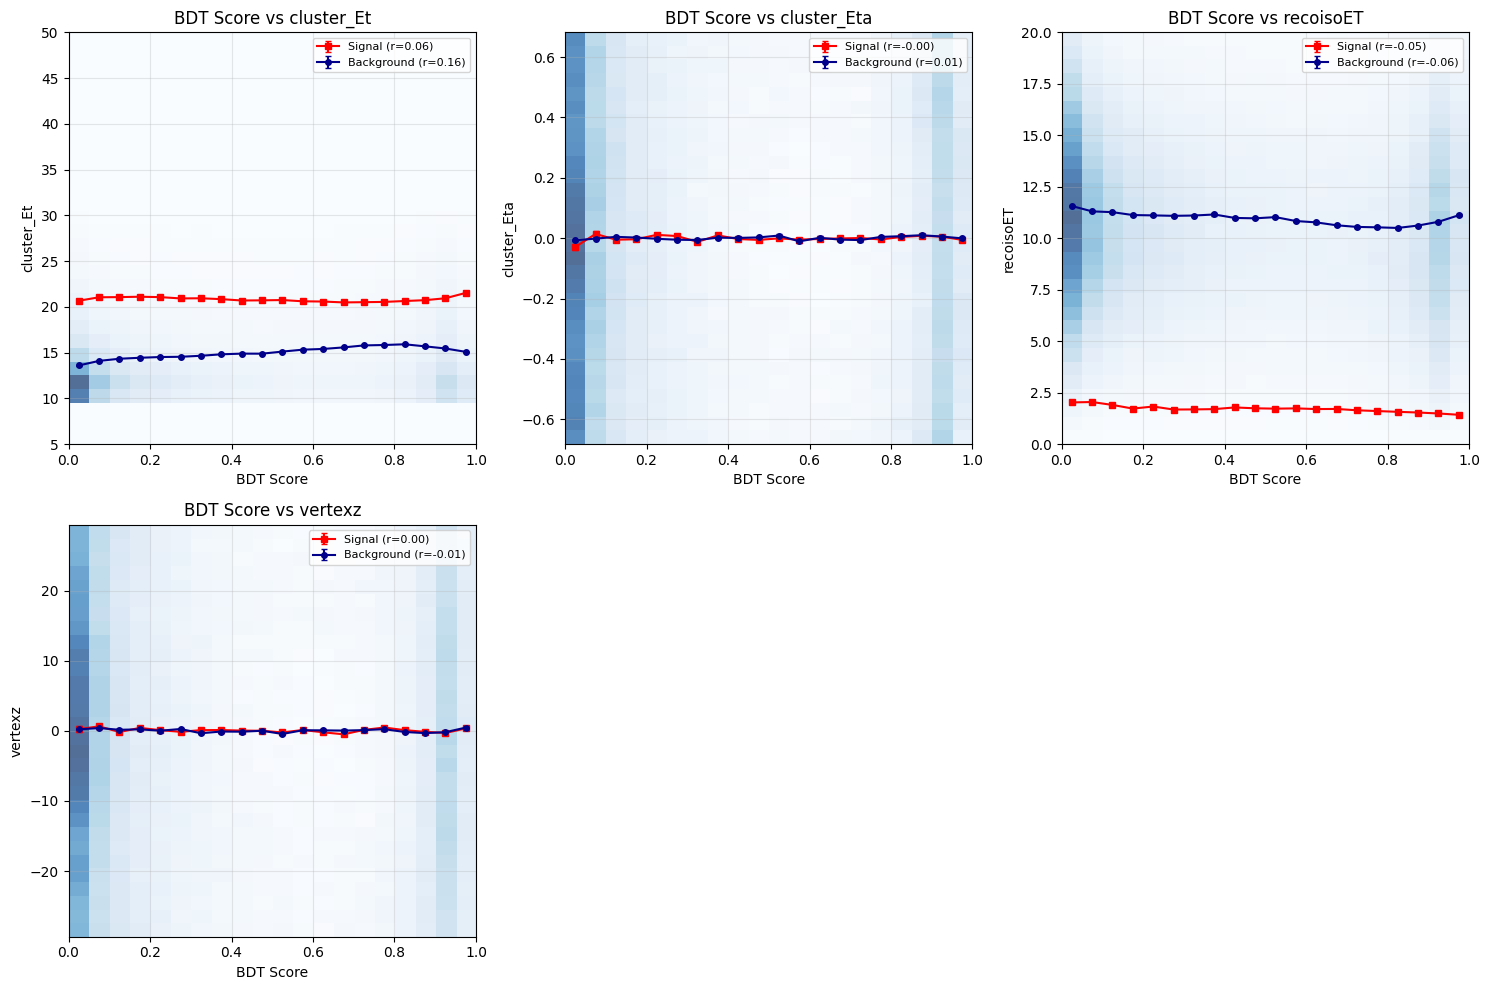


Creating complementary plots with features on x-axis and BDT score on y-axis...


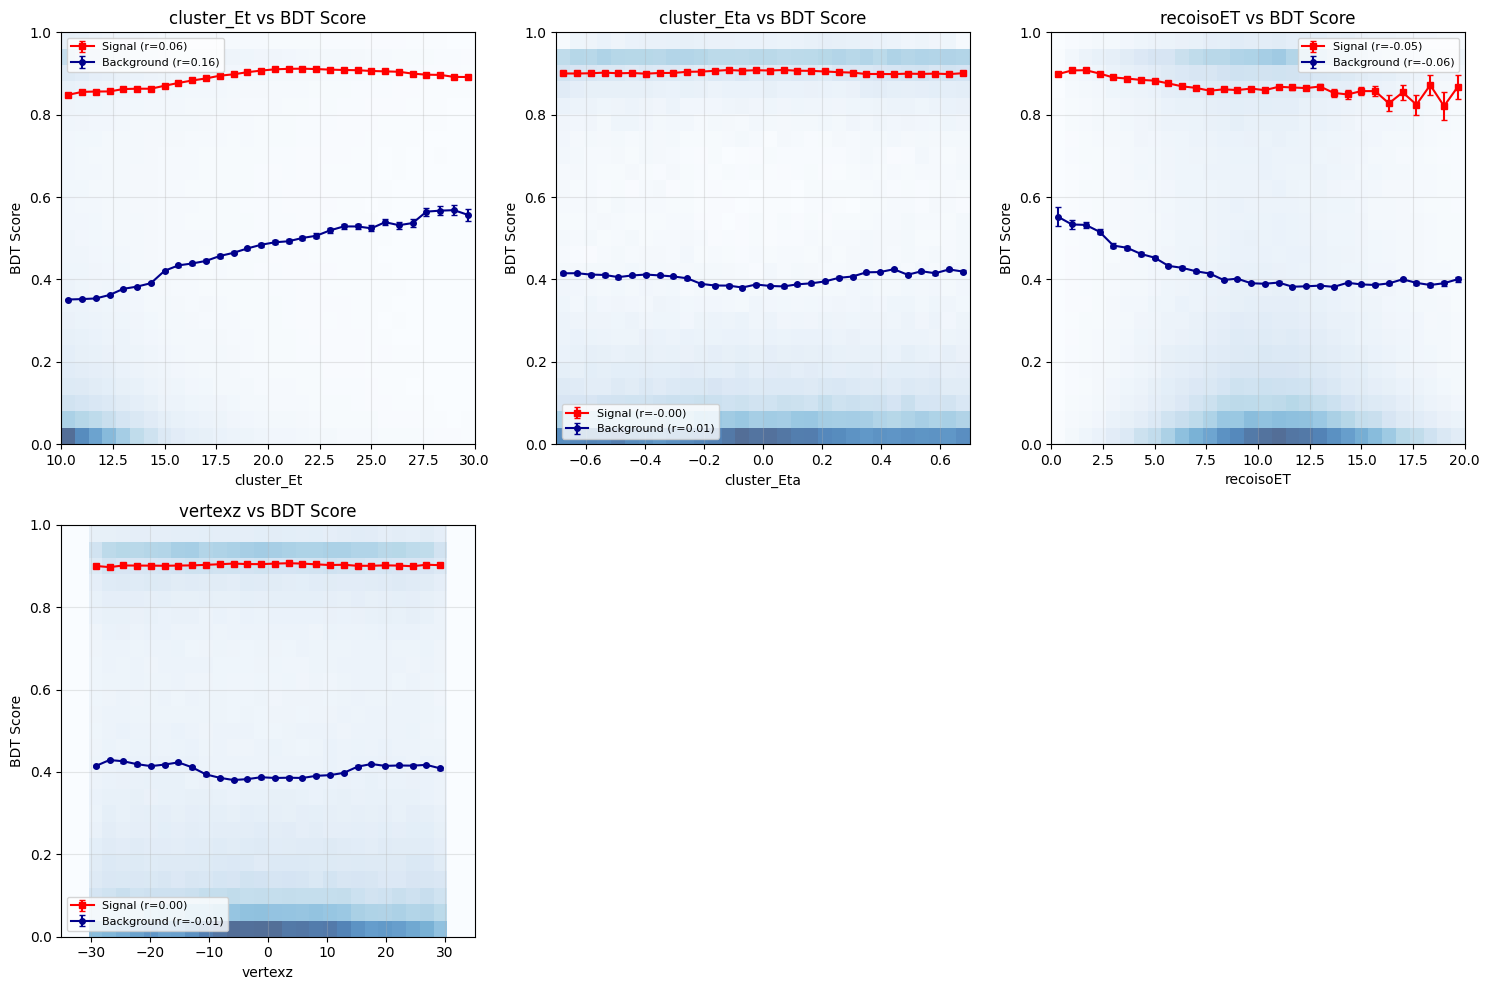

\nCorrelation summary:
Features with strongest correlations (|r| > 0.1):
  cluster_Et          : Signal r=+0.056, Background r=+0.164
\nBoth correlation plot orientations complete!
First set: BDT score (x) vs features (y) - shows how features change with BDT score
Second set: Features (x) vs BDT score (y) - shows how BDT score responses to feature values
\n=== VERTEX-BINNED BDT SCORE CORRELATION ANALYSIS ===
Creating BDT score vs vertexz plots for vertex-binned models...
\nBoth correlation plot orientations complete!
First set: BDT score (x) vs features (y) - shows how features change with BDT score
Second set: Features (x) vs BDT score (y) - shows how BDT score responses to feature values
\n=== VERTEX-BINNED BDT SCORE CORRELATION ANALYSIS ===
Creating BDT score vs vertexz plots for vertex-binned models...


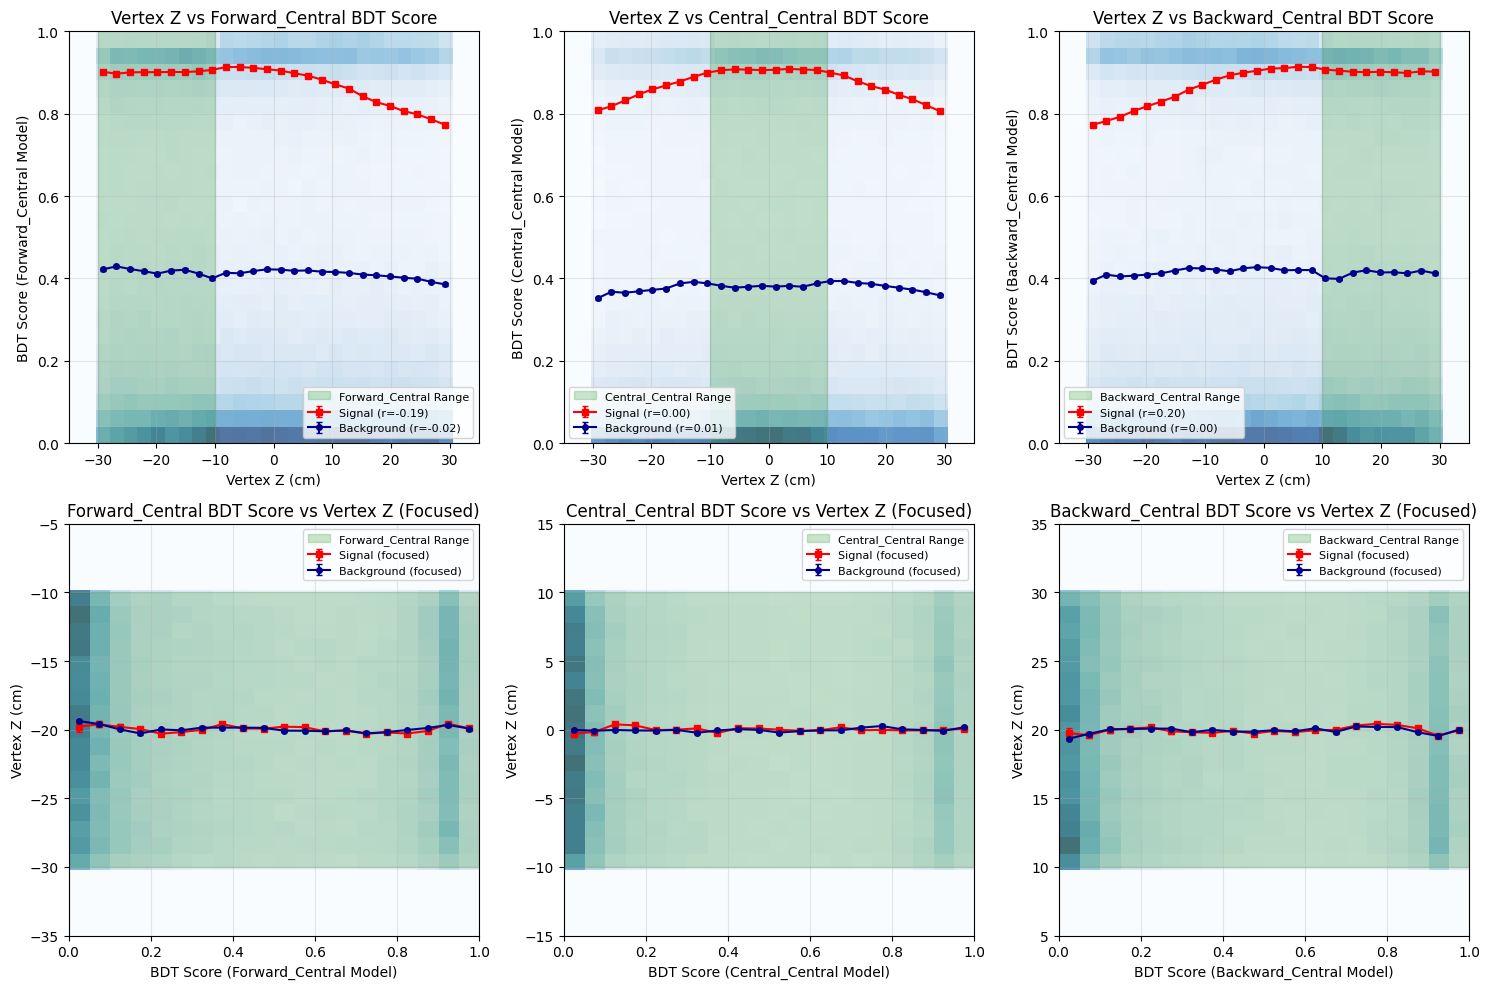

\n=== VERTEX-BINNED CORRELATION SUMMARY ===
Model        Signal r   Background r  Vertex Range
--------------------------------------------------
Forward_Central -0.192     -0.019        [-30, -10]
Central_Central +0.001     +0.007        [-10, +10]
Backward_Central +0.196     +0.003        [+10, +30]
\nVertex-binned BDT score correlation analysis complete!
• Top plots show how BDT scores vary across the full vertex range
• Bottom plots focus on each model's specific vertex range
• Green shaded regions indicate the training range for each vertex-specific model
Central_Central +0.001     +0.007        [-10, +10]
Backward_Central +0.196     +0.003        [+10, +30]
\nVertex-binned BDT score correlation analysis complete!
• Top plots show how BDT scores vary across the full vertex range
• Bottom plots focus on each model's specific vertex range
• Green shaded regions indicate the training range for each vertex-specific model


In [ ]:
# Create correlation plots for each feature
n_features = len(correlation_features)
n_cols = 3  # Number of columns in subplot grid
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate rows needed

# Separate signal and background data
mask_sig = df_weighted["label"] == 1
mask_bkg = df_weighted["label"] == 0

bdt_scores_sig = df_weighted.loc[mask_sig, "bdt_score"].values
bdt_scores_bkg = df_weighted.loc[mask_bkg, "bdt_score"].values
weights_sig = df_weighted.loc[mask_sig, "weight"].values
weights_bkg = df_weighted.loc[mask_bkg, "weight"].values

print(f"Processing {len(correlation_features)} features for correlation analysis...")

# =================================================================================
# PLOT 1: BDT Score (x-axis) vs Features (y-axis) 
# =================================================================================
print("Creating plots with BDT score on x-axis and features on y-axis...")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

# Flatten axes array for easier indexing
axes_flat = axes.flatten()

for idx, feature in enumerate(correlation_features):
    ax = axes_flat[idx]
    
    # Check if feature exists in dataframe
    if feature not in df_weighted.columns:
        ax.text(0.5, 0.5, f"Feature '{feature}'\nnot available", 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"{feature} (N/A)")
        continue
    
    # Get feature data
    feature_sig = df_weighted.loc[mask_sig, feature].values
    feature_bkg = df_weighted.loc[mask_bkg, feature].values
    
    # Clean data (remove NaN/inf)
    sig_mask = np.isfinite(feature_sig) & np.isfinite(bdt_scores_sig) & np.isfinite(weights_sig)
    bkg_mask = np.isfinite(feature_bkg) & np.isfinite(bdt_scores_bkg) & np.isfinite(weights_bkg)
    
    if np.sum(sig_mask) < 10 or np.sum(bkg_mask) < 10:
        ax.text(0.5, 0.5, f"Feature '{feature}'\ninsufficient data", 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"{feature} (insufficient data)")
        continue
    
    feat_sig_clean = feature_sig[sig_mask]
    feat_bkg_clean = feature_bkg[bkg_mask]
    bdt_sig_clean = bdt_scores_sig[sig_mask]
    bdt_bkg_clean = bdt_scores_bkg[bkg_mask]
    w_sig_clean = weights_sig[sig_mask]
    w_bkg_clean = weights_bkg[bkg_mask]
    
    # Set up bins
    bdt_edges = np.linspace(0, 1, 21)  # BDT score bins (x-axis)
    
    # Calculate profiles and correlations
    c_sig, m_sig, se_sig = weighted_profile_with_err(bdt_sig_clean, feat_sig_clean, w_sig_clean, bdt_edges)
    c_bkg, m_bkg, se_bkg = weighted_profile_with_err(bdt_bkg_clean, feat_bkg_clean, w_bkg_clean, bdt_edges)
    
    r_sig = wpearson(bdt_sig_clean, feat_sig_clean, w_sig_clean)
    r_bkg = wpearson(bdt_bkg_clean, feat_bkg_clean, w_bkg_clean)
    
    # Create 2D histogram for background (more data usually)
    try:
        # Define feature range for y-axis
        if feature == "recoisoET":
            feat_range = (0, 20)  # Focus on low isolation
        elif feature == "cluster_Et":
            feat_range = (5, 50)
        else:
            # Auto-range based on percentiles
            feat_all = np.concatenate([feat_sig_clean, feat_bkg_clean])
            feat_range = (np.percentile(feat_all, 1), np.percentile(feat_all, 99))
        
        # Create 2D histogram
        hist_bkg, xedges, yedges = np.histogram2d(bdt_bkg_clean, feat_bkg_clean, 
                                                  bins=[bdt_edges, 30], 
                                                  range=[[0, 1], feat_range],
                                                  weights=w_bkg_clean)
        
        # Plot 2D histogram
        im = ax.imshow(hist_bkg.T, origin='lower', aspect='auto', 
                      extent=[0, 1, feat_range[0], feat_range[1]], 
                      cmap='Blues', alpha=0.7)
        
        # Overlay profiles with error bars
        ax.errorbar(c_sig, m_sig, yerr=se_sig, fmt='s-', color='red', 
                   markersize=4, linewidth=1.5, capsize=2,
                   label=f'Signal (r={r_sig:.2f})' if np.isfinite(r_sig) else 'Signal')
        
        ax.errorbar(c_bkg, m_bkg, yerr=se_bkg, fmt='o-', color='darkblue', 
                   markersize=4, linewidth=1.5, capsize=2,
                   label=f'Background (r={r_bkg:.2f})' if np.isfinite(r_bkg) else 'Background')
    
    except Exception as e:
        # Fallback to simple profile plots if 2D histogram fails
        ax.errorbar(c_sig, m_sig, yerr=se_sig, fmt='s-', color='red', 
                   markersize=4, linewidth=1.5, capsize=2,
                   label=f'Signal (r={r_sig:.2f})' if np.isfinite(r_sig) else 'Signal')
        
        ax.errorbar(c_bkg, m_bkg, yerr=se_bkg, fmt='o-', color='blue', 
                   markersize=4, linewidth=1.5, capsize=2,
                   label=f'Background (r={r_bkg:.2f})' if np.isfinite(r_bkg) else 'Background')
    
    # Formatting
    ax.set_xlabel('BDT Score')
    ax.set_ylabel(feature)
    ax.set_title(f'BDT Score vs {feature}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1)

# Remove empty subplots
for idx in range(n_features, len(axes_flat)):
    fig.delaxes(axes_flat[idx])

plt.tight_layout()
plt.show()

# =================================================================================
# PLOT 2: Features (x-axis) vs BDT Score (y-axis) - Complementary View
# =================================================================================
print("\nCreating complementary plots with features on x-axis and BDT score on y-axis...")

fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
if n_rows == 1:
    axes2 = axes2.reshape(1, -1)

# Flatten axes array for easier indexing
axes2_flat = axes2.flatten()

for idx, feature in enumerate(correlation_features):
    ax = axes2_flat[idx]
    
    # Check if feature exists in dataframe
    if feature not in df_weighted.columns:
        ax.text(0.5, 0.5, f"Feature '{feature}'\nnot available", 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"{feature} (N/A)")
        continue
    
    # Get feature data (same as before)
    feature_sig = df_weighted.loc[mask_sig, feature].values
    feature_bkg = df_weighted.loc[mask_bkg, feature].values
    
    # Clean data (remove NaN/inf)
    sig_mask = np.isfinite(feature_sig) & np.isfinite(bdt_scores_sig) & np.isfinite(weights_sig)
    bkg_mask = np.isfinite(feature_bkg) & np.isfinite(bdt_scores_bkg) & np.isfinite(weights_bkg)
    
    if np.sum(sig_mask) < 10 or np.sum(bkg_mask) < 10:
        ax.text(0.5, 0.5, f"Feature '{feature}'\ninsufficient data", 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"{feature} (insufficient data)")
        continue
    
    feat_sig_clean = feature_sig[sig_mask]
    feat_bkg_clean = feature_bkg[bkg_mask]
    bdt_sig_clean = bdt_scores_sig[sig_mask]
    bdt_bkg_clean = bdt_scores_bkg[bkg_mask]
    w_sig_clean = weights_sig[sig_mask]
    w_bkg_clean = weights_bkg[bkg_mask]
    
    # Determine feature range for x-axis
    if feature == "recoisoET":
        feat_range = (0, 20)
    elif feature == "cluster_Et":
        feat_range = (10, 30)  # Match the Et reweighting range
    elif feature == "cluster_Eta":
        feat_range = (-0.7, 0.7)  # Match the Eta reweighting range
    elif feature == "vertexz":
        feat_range = (-60, 60)  # Typical vertex z range
    else:
        # Auto-range based on percentiles
        feat_all = np.concatenate([feat_sig_clean, feat_bkg_clean])
        feat_range = (np.percentile(feat_all, 1), np.percentile(feat_all, 99))
    
    # Set up feature bins (x-axis) - more bins for better resolution
    feat_edges = np.linspace(feat_range[0], feat_range[1], 31)
    
    # Calculate profiles (now feature -> BDT score)
    c_sig_x, m_sig_y, se_sig_y = weighted_profile_with_err(feat_sig_clean, bdt_sig_clean, w_sig_clean, feat_edges)
    c_bkg_x, m_bkg_y, se_bkg_y = weighted_profile_with_err(feat_bkg_clean, bdt_bkg_clean, w_bkg_clean, feat_edges)
    
    # Same correlation coefficients (symmetrical)
    r_sig = wpearson(bdt_sig_clean, feat_sig_clean, w_sig_clean)
    r_bkg = wpearson(bdt_bkg_clean, feat_bkg_clean, w_bkg_clean)
    
    # Create 2D histogram for background (feature vs BDT score)
    try:
        hist_bkg_xy, xedges_xy, yedges_xy = np.histogram2d(feat_bkg_clean, bdt_bkg_clean, 
                                                          bins=[30, 25], 
                                                          range=[feat_range, [0, 1]],
                                                          weights=w_bkg_clean)
        
        # Plot 2D histogram
        im = ax.imshow(hist_bkg_xy.T, origin='lower', aspect='auto', 
                      extent=[feat_range[0], feat_range[1], 0, 1], 
                      cmap='Blues', alpha=0.7)
        
        # Overlay profiles with error bars
        ax.errorbar(c_sig_x, m_sig_y, yerr=se_sig_y, fmt='s-', color='red', 
                   markersize=4, linewidth=1.5, capsize=2,
                   label=f'Signal (r={r_sig:.2f})' if np.isfinite(r_sig) else 'Signal')
        
        ax.errorbar(c_bkg_x, m_bkg_y, yerr=se_bkg_y, fmt='o-', color='darkblue', 
                   markersize=4, linewidth=1.5, capsize=2,
                   label=f'Background (r={r_bkg:.2f})' if np.isfinite(r_bkg) else 'Background')
    
    except Exception as e:
        # Fallback to simple profile plots if 2D histogram fails
        ax.errorbar(c_sig_x, m_sig_y, yerr=se_sig_y, fmt='s-', color='red', 
                   markersize=4, linewidth=1.5, capsize=2,
                   label=f'Signal (r={r_sig:.2f})' if np.isfinite(r_sig) else 'Signal')
        
        ax.errorbar(c_bkg_x, m_bkg_y, yerr=se_bkg_y, fmt='o-', color='blue', 
                   markersize=4, linewidth=1.5, capsize=2,
                   label=f'Background (r={r_bkg:.2f})' if np.isfinite(r_bkg) else 'Background')
    
    # Formatting
    ax.set_xlabel(feature)
    ax.set_ylabel('BDT Score')
    ax.set_title(f'{feature} vs BDT Score')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    ax.set_xlim(feat_range)

# Remove empty subplots
for idx in range(n_features, len(axes2_flat)):
    fig2.delaxes(axes2_flat[idx])

plt.tight_layout()
plt.show()

print("\\nCorrelation summary:")
print("Features with strongest correlations (|r| > 0.1):")
for feature in correlation_features:
    if feature in df_weighted.columns:
        # Calculate correlations for summary
        mask_sig_clean = mask_sig & np.isfinite(df_weighted[feature]) & np.isfinite(df_weighted["bdt_score"])
        mask_bkg_clean = mask_bkg & np.isfinite(df_weighted[feature]) & np.isfinite(df_weighted["bdt_score"])
        
        if np.sum(mask_sig_clean) > 10:
            r_sig = wpearson(df_weighted.loc[mask_sig_clean, "bdt_score"].values,
                           df_weighted.loc[mask_sig_clean, feature].values,
                           df_weighted.loc[mask_sig_clean, "weight"].values)
        else:
            r_sig = np.nan
            
        if np.sum(mask_bkg_clean) > 10:
            r_bkg = wpearson(df_weighted.loc[mask_bkg_clean, "bdt_score"].values,
                           df_weighted.loc[mask_bkg_clean, feature].values,
                           df_weighted.loc[mask_bkg_clean, "weight"].values)
        else:
            r_bkg = np.nan
        
        if (np.isfinite(r_sig) and abs(r_sig) > 0.1) or (np.isfinite(r_bkg) and abs(r_bkg) > 0.1):
            print(f"  {feature:<20}: Signal r={r_sig:+.3f}, Background r={r_bkg:+.3f}" 
                  if np.isfinite(r_sig) and np.isfinite(r_bkg) 
                  else f"  {feature:<20}: Limited data for correlation")

print("\\nBoth correlation plot orientations complete!")
print("First set: BDT score (x) vs features (y) - shows how features change with BDT score")
print("Second set: Features (x) vs BDT score (y) - shows how BDT score responses to feature values")

# =================================================================================
# PLOT 3: Vertex-Binned BDT Score vs VertexZ Analysis
# =================================================================================
if ENABLE_VERTEX_BINNING and vertex_models and any(model is not None for model in vertex_models.values()):
    print("\\n=== VERTEX-BINNED BDT SCORE CORRELATION ANALYSIS ===")
    print("Creating BDT score vs vertexz plots for vertex-binned models...")
    
    # Create vertex-binned BDT scores for the full dataset
    df_vertex_analysis = df_weighted.copy()
    
    # Add vertex-binned BDT scores to the dataframe
    for bin_label, model_vertex in vertex_models.items():
        if model_vertex is not None:
            # Generate predictions for all data using this vertex-specific model
            try:
                vertex_scores = model_vertex.predict_proba(df_vertex_analysis[features])[:, 1]
                df_vertex_analysis[f"bdt_score_{bin_label.lower()}"] = vertex_scores
            except Exception as e:
                print(f"  Error generating scores for {bin_label} model: {e}")
                continue
    
    # Create comprehensive vertex-binned correlation plots
    n_models = len([model for model in vertex_models.values() if model is not None])
    
    if n_models > 0:
        fig3, axes3 = plt.subplots(2, n_models, figsize=(5*n_models, 10))
        if n_models == 1:
            axes3 = axes3.reshape(2, 1)
        
        model_idx = 0
        for bin_label, model_vertex in vertex_models.items():
            if model_vertex is None:
                continue
                
            # Get vertex range for this model
            if bin_label in vertex_results and vertex_results[bin_label] is not None:
                vz_min, vz_max = vertex_results[bin_label]['vertex_range']
            else:
                # Fall back to centralized bin definitions
                found_range = False
                for vz_range_min, vz_range_max, vz_label in vertex_z_bins:
                    if vz_label in bin_label:
                        vz_min, vz_max = vz_range_min, vz_range_max
                        found_range = True
                        break
                
                if not found_range:
                    # Use full range as fallback
                    vz_min, vz_max = -35, 35
            
            score_column = f"bdt_score_{bin_label.lower()}"
            if score_column not in df_vertex_analysis.columns:
                continue
            
            # Separate signal and background for this vertex-binned model
            mask_sig_v = df_vertex_analysis["label"] == 1
            mask_bkg_v = df_vertex_analysis["label"] == 0
            
            # Get data for plotting
            vertexz_sig = df_vertex_analysis.loc[mask_sig_v, "vertexz"].values
            vertexz_bkg = df_vertex_analysis.loc[mask_bkg_v, "vertexz"].values
            scores_sig = df_vertex_analysis.loc[mask_sig_v, score_column].values
            scores_bkg = df_vertex_analysis.loc[mask_bkg_v, score_column].values
            weights_sig_v = df_vertex_analysis.loc[mask_sig_v, "weight"].values
            weights_bkg_v = df_vertex_analysis.loc[mask_bkg_v, "weight"].values
            
            # Clean data
            sig_mask_clean = (np.isfinite(vertexz_sig) & np.isfinite(scores_sig) & 
                            np.isfinite(weights_sig_v) & (weights_sig_v > 0))
            bkg_mask_clean = (np.isfinite(vertexz_bkg) & np.isfinite(scores_bkg) & 
                            np.isfinite(weights_bkg_v) & (weights_bkg_v > 0))
            
            if np.sum(sig_mask_clean) < 10 or np.sum(bkg_mask_clean) < 10:
                print(f"  Insufficient clean data for {bin_label} model")
                continue
            
            vertexz_sig_clean = vertexz_sig[sig_mask_clean]
            vertexz_bkg_clean = vertexz_bkg[bkg_mask_clean]
            scores_sig_clean = scores_sig[sig_mask_clean]
            scores_bkg_clean = scores_bkg[bkg_mask_clean]
            weights_sig_clean = weights_sig_v[sig_mask_clean]
            weights_bkg_clean = weights_bkg_v[bkg_mask_clean]
            
            # Set vertex range for plotting
            vz_plot_range = (-35, 35)
            vz_edges = np.linspace(vz_plot_range[0], vz_plot_range[1], 31)
            
            # Calculate profiles: vertexz vs BDT score
            c_sig_vz, m_sig_score, se_sig_score = weighted_profile_with_err(
                vertexz_sig_clean, scores_sig_clean, weights_sig_clean, vz_edges)
            c_bkg_vz, m_bkg_score, se_bkg_score = weighted_profile_with_err(
                vertexz_bkg_clean, scores_bkg_clean, weights_bkg_clean, vz_edges)
            
            # Calculate correlations
            r_sig_vz = wpearson(vertexz_sig_clean, scores_sig_clean, weights_sig_clean)
            r_bkg_vz = wpearson(vertexz_bkg_clean, scores_bkg_clean, weights_bkg_clean)
            
            # ======================
            # Top plot: vertexz (x) vs BDT score (y)
            # ======================
            ax_top = axes3[0, model_idx]
            
            # 2D histogram for background
            try:
                hist_bkg_vz, xedges_vz, yedges_vz = np.histogram2d(
                    vertexz_bkg_clean, scores_bkg_clean, 
                    bins=[30, 25], range=[vz_plot_range, [0, 1]],
                    weights=weights_bkg_clean)
                
                im_vz = ax_top.imshow(hist_bkg_vz.T, origin='lower', aspect='auto',
                                    extent=[vz_plot_range[0], vz_plot_range[1], 0, 1],
                                    cmap='Blues', alpha=0.7)
            except:
                pass  # Skip 2D histogram if it fails
            
            # Overlay profiles
            ax_top.errorbar(c_sig_vz, m_sig_score, yerr=se_sig_score, fmt='s-', 
                          color='red', markersize=4, linewidth=1.5, capsize=2,
                          label=f'Signal (r={r_sig_vz:.2f})' if np.isfinite(r_sig_vz) else 'Signal')
            ax_top.errorbar(c_bkg_vz, m_bkg_score, yerr=se_bkg_score, fmt='o-',
                          color='darkblue', markersize=4, linewidth=1.5, capsize=2,
                          label=f'Background (r={r_bkg_vz:.2f})' if np.isfinite(r_bkg_vz) else 'Background')
            
            # Highlight this model's vertex range
            ax_top.axvspan(vz_min, vz_max, alpha=0.2, color='green', 
                         label=f'{bin_label} Range')
            
            ax_top.set_xlabel('Vertex Z (cm)')
            ax_top.set_ylabel(f'BDT Score ({bin_label} Model)')
            ax_top.set_title(f'Vertex Z vs {bin_label} BDT Score')
            ax_top.legend(fontsize=8)
            ax_top.grid(True, alpha=0.3)
            ax_top.set_xlim(vz_plot_range)
            ax_top.set_ylim(0, 1)
            
            # ======================
            # Bottom plot: BDT score (x) vs vertexz (y) - focus on model's range
            # ======================
            ax_bottom = axes3[1, model_idx]
            
            # Filter data to focus on this model's vertex range for better resolution
            in_range_sig = (vertexz_sig_clean >= vz_min) & (vertexz_sig_clean < vz_max)
            in_range_bkg = (vertexz_bkg_clean >= vz_min) & (vertexz_bkg_clean < vz_max)
            
            if np.sum(in_range_sig) > 10 and np.sum(in_range_bkg) > 10:
                # Use only data in this vertex range for focused analysis
                vz_sig_focus = vertexz_sig_clean[in_range_sig]
                vz_bkg_focus = vertexz_bkg_clean[in_range_bkg]
                score_sig_focus = scores_sig_clean[in_range_sig]
                score_bkg_focus = scores_bkg_clean[in_range_bkg]
                weight_sig_focus = weights_sig_clean[in_range_sig]
                weight_bkg_focus = weights_bkg_clean[in_range_bkg]
            else:
                # Fall back to all data if insufficient data in range
                vz_sig_focus = vertexz_sig_clean
                vz_bkg_focus = vertexz_bkg_clean  
                score_sig_focus = scores_sig_clean
                score_bkg_focus = scores_bkg_clean
                weight_sig_focus = weights_sig_clean
                weight_bkg_focus = weights_bkg_clean
            
            # BDT score bins (x-axis)
            score_edges = np.linspace(0, 1, 21)
            
            # Calculate profiles: BDT score vs vertexz (focused)
            c_score, m_vz_sig_focus, se_vz_sig_focus = weighted_profile_with_err(
                score_sig_focus, vz_sig_focus, weight_sig_focus, score_edges)
            c_score_bkg, m_vz_bkg_focus, se_vz_bkg_focus = weighted_profile_with_err(
                score_bkg_focus, vz_bkg_focus, weight_bkg_focus, score_edges)
            
            # 2D histogram for background (BDT score vs vertex z)
            try:
                hist_focus, xedges_focus, yedges_focus = np.histogram2d(
                    score_bkg_focus, vz_bkg_focus,
                    bins=[20, 25], range=[[0, 1], [vz_min-5, vz_max+5]],
                    weights=weight_bkg_focus)
                
                im_focus = ax_bottom.imshow(hist_focus.T, origin='lower', aspect='auto',
                                          extent=[0, 1, vz_min-5, vz_max+5],
                                          cmap='Blues', alpha=0.7)
            except:
                pass  # Skip 2D histogram if it fails
            
            # Overlay profiles
            ax_bottom.errorbar(c_score, m_vz_sig_focus, yerr=se_vz_sig_focus, fmt='s-',
                             color='red', markersize=4, linewidth=1.5, capsize=2,
                             label=f'Signal (focused)')
            ax_bottom.errorbar(c_score_bkg, m_vz_bkg_focus, yerr=se_vz_bkg_focus, fmt='o-',
                             color='darkblue', markersize=4, linewidth=1.5, capsize=2,
                             label=f'Background (focused)')
            
            # Highlight this model's vertex range
            ax_bottom.axhspan(vz_min, vz_max, alpha=0.2, color='green',
                            label=f'{bin_label} Range')
            
            ax_bottom.set_xlabel(f'BDT Score ({bin_label} Model)')
            ax_bottom.set_ylabel('Vertex Z (cm)')
            ax_bottom.set_title(f'{bin_label} BDT Score vs Vertex Z (Focused)')
            ax_bottom.legend(fontsize=8)
            ax_bottom.grid(True, alpha=0.3)
            ax_bottom.set_xlim(0, 1)
            ax_bottom.set_ylim(vz_min-5, vz_max+5)
            
            model_idx += 1
        
        plt.tight_layout()
        plt.show()
        
        # Summary of vertex-binned correlations
        print("\\n=== VERTEX-BINNED CORRELATION SUMMARY ===")
        print(f"{'Model':<12} {'Signal r':<10} {'Background r':<13} {'Vertex Range'}")
        print("-" * 50)
        
        for bin_label, model_vertex in vertex_models.items():
            if model_vertex is not None and f"bdt_score_{bin_label.lower()}" in df_vertex_analysis.columns:
                score_col = f"bdt_score_{bin_label.lower()}"
                
                # Calculate correlations for summary
                mask_sig_clean = (mask_sig & np.isfinite(df_vertex_analysis["vertexz"]) & 
                                np.isfinite(df_vertex_analysis[score_col]))
                mask_bkg_clean = (mask_bkg & np.isfinite(df_vertex_analysis["vertexz"]) & 
                                np.isfinite(df_vertex_analysis[score_col]))
                
                if np.sum(mask_sig_clean) > 10:
                    r_sig = wpearson(df_vertex_analysis.loc[mask_sig_clean, "vertexz"].values,
                                   df_vertex_analysis.loc[mask_sig_clean, score_col].values,
                                   df_vertex_analysis.loc[mask_sig_clean, "weight"].values)
                else:
                    r_sig = np.nan
                
                if np.sum(mask_bkg_clean) > 10:
                    r_bkg = wpearson(df_vertex_analysis.loc[mask_bkg_clean, "vertexz"].values,
                                   df_vertex_analysis.loc[mask_bkg_clean, score_col].values,
                                   df_vertex_analysis.loc[mask_bkg_clean, "weight"].values)
                else:
                    r_bkg = np.nan
                
                # Get vertex range
                if bin_label in vertex_results and vertex_results[bin_label] is not None:
                    vz_min, vz_max = vertex_results[bin_label]['vertex_range']
                    range_str = f"[{vz_min:+.0f}, {vz_max:+.0f}]"
                else:
                    range_str = "Unknown"
                
                r_sig_str = f"{r_sig:+.3f}" if np.isfinite(r_sig) else "N/A"
                r_bkg_str = f"{r_bkg:+.3f}" if np.isfinite(r_bkg) else "N/A"
                
                print(f"{bin_label:<12} {r_sig_str:<10} {r_bkg_str:<13} {range_str}")
        
        print("\\nVertex-binned BDT score correlation analysis complete!")
        print("• Top plots show how BDT scores vary across the full vertex range")
        print("• Bottom plots focus on each model's specific vertex range")
        print("• Green shaded regions indicate the training range for each vertex-specific model")
    
    else:
        print("No valid vertex-binned models found for correlation analysis.")

else:
    print("\\nVertex-binned correlation analysis skipped (vertex binning disabled or no models).")

\n=== COMBINED VERTEX-BINNED BDT PERFORMANCE ===
Creating combined plot showing BDT scores vs vertex position for each model in its range...
  Processing Forward_Central model for vertex range [-30, -10] cm
    Added 424405 signal, 100904 background samples
  Processing Central_Central model for vertex range [-10, 10] cm
    Added 424405 signal, 100904 background samples
  Processing Central_Central model for vertex range [-10, 10] cm
    Added 444361 signal, 108592 background samples
  Processing Backward_Central model for vertex range [10, 30] cm
    Added 444361 signal, 108592 background samples
  Processing Backward_Central model for vertex range [10, 30] cm
    Added 426392 signal, 102147 background samples
    Added 426392 signal, 102147 background samples


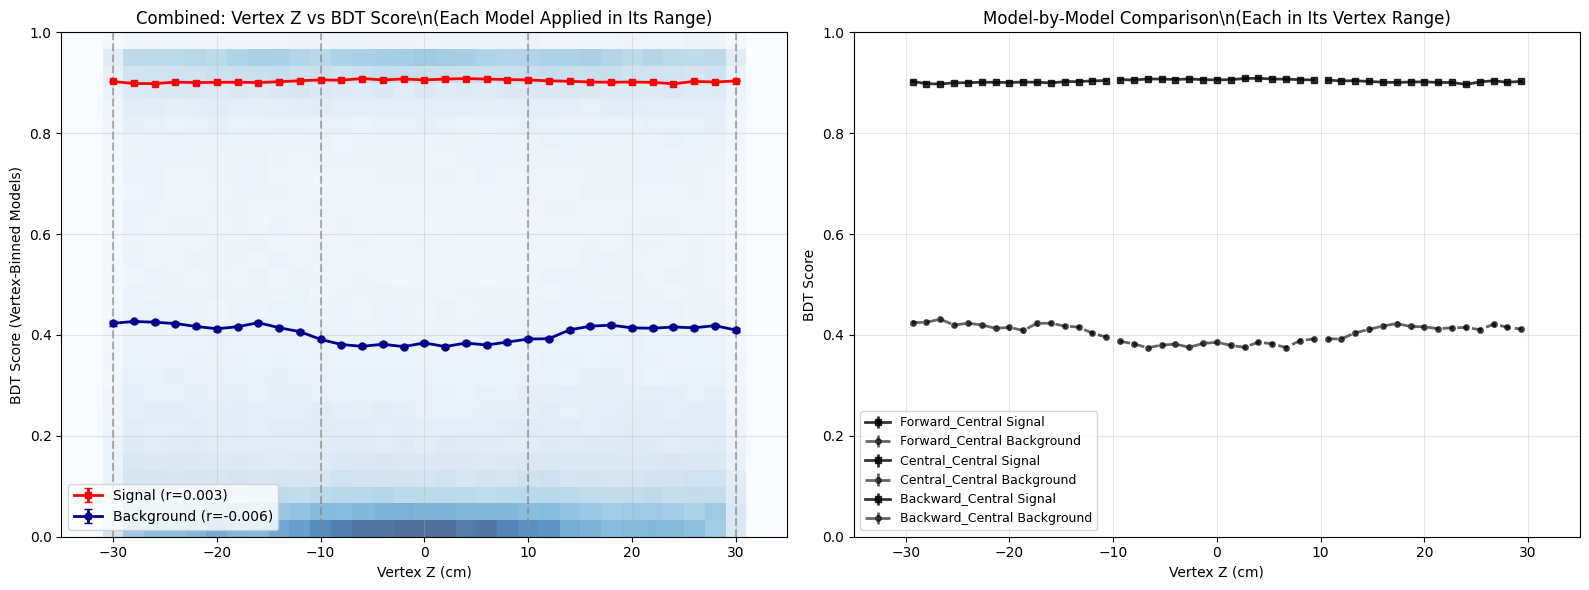

\n=== COMBINED PERFORMANCE SUMMARY ===
Total samples analyzed:
  Signal:     1,295,158 events
  Background: 311,643 events
\nOverall correlations (vertex-binned models in their ranges):
  Signal:     r = +0.003
  Background: r = -0.006
\nModel contributions:
Model        Vertex Range    Signal   Background
--------------------------------------------------
Forward_Central [-30, -10]      424,405  100,904   
Central_Central [-10, +10]      444,361  108,592   
Backward_Central [+10, +30]      426,392  102,147   
\nCombined vertex-binned analysis complete!
• Left plot: Overall performance across the full vertex range
• Right plot: Individual model contributions in their specific ranges
• Dashed vertical lines show boundaries between vertex regions
• Each model is evaluated only on data within its training vertex range


In [ ]:
# Combined Plot: BDT Score vs Vertex Position (Each Model in Its Range)
if ENABLE_VERTEX_BINNING and vertex_models and any(model is not None for model in vertex_models.values()):
    print("\\n=== COMBINED VERTEX-BINNED BDT PERFORMANCE ===")
    print("Creating combined plot showing BDT scores vs vertex position for each model in its range...")
    
    # Create the combined plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Define colors for different models (using centralized bin labels)
    model_colors = {}
    color_palette = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']
    for i, (_, _, label) in enumerate(vertex_z_bins):
        model_colors[label] = color_palette[i % len(color_palette)]
    
    # Collect data for combined analysis
    combined_data = {'Signal': {'vz': [], 'scores': [], 'weights': [], 'model': []},
                     'Background': {'vz': [], 'scores': [], 'weights': [], 'model': []}}
    
    # Process each vertex-binned model
    for bin_label, model_vertex in vertex_models.items():
        if model_vertex is None:
            continue
            
        # Get vertex range for this model
        if bin_label in vertex_results and vertex_results[bin_label] is not None:
            vz_min, vz_max = vertex_results[bin_label]['vertex_range']
        else:
            # Fall back to centralized bin definitions
            found_range = False
            for vz_range_min, vz_range_max, vz_label in vertex_z_bins:
                if vz_label in bin_label:
                    vz_min, vz_max = vz_range_min, vz_range_max
                    found_range = True
                    break
            
            if not found_range:
                print(f"    Warning: Could not determine vertex range for {bin_label}, skipping")
                continue
        
        print(f"  Processing {bin_label} model for vertex range [{vz_min}, {vz_max}] cm")
        
        # Filter data to this vertex range only
        vertex_mask = (df_weighted["vertexz"] >= vz_min) & (df_weighted["vertexz"] < vz_max)
        df_range = df_weighted.loc[vertex_mask].copy()
        
        if len(df_range) < 50:  # Minimum samples for meaningful analysis
            print(f"    Insufficient samples in range: {len(df_range)}")
            continue
        
        # Generate BDT scores using this vertex-specific model
        try:
            range_scores = model_vertex.predict_proba(df_range[features])[:, 1]
        except Exception as e:
            print(f"    Error generating scores for {bin_label}: {e}")
            continue
        
        # Separate signal and background in this range
        sig_mask_range = df_range["label"] == 1
        bkg_mask_range = df_range["label"] == 0
        
        # Collect data for signal
        if np.sum(sig_mask_range) > 0:
            vz_sig = df_range.loc[sig_mask_range, "vertexz"].values
            scores_sig = range_scores[sig_mask_range]
            weights_sig = df_range.loc[sig_mask_range, "weight"].values
            
            # Clean data
            clean_mask = np.isfinite(vz_sig) & np.isfinite(scores_sig) & np.isfinite(weights_sig)
            if np.sum(clean_mask) > 0:
                combined_data['Signal']['vz'].extend(vz_sig[clean_mask])
                combined_data['Signal']['scores'].extend(scores_sig[clean_mask])
                combined_data['Signal']['weights'].extend(weights_sig[clean_mask])
                combined_data['Signal']['model'].extend([bin_label] * np.sum(clean_mask))
        
        # Collect data for background
        if np.sum(bkg_mask_range) > 0:
            vz_bkg = df_range.loc[bkg_mask_range, "vertexz"].values
            scores_bkg = range_scores[bkg_mask_range]
            weights_bkg = df_range.loc[bkg_mask_range, "weight"].values
            
            # Clean data
            clean_mask = np.isfinite(vz_bkg) & np.isfinite(scores_bkg) & np.isfinite(weights_bkg)
            if np.sum(clean_mask) > 0:
                combined_data['Background']['vz'].extend(vz_bkg[clean_mask])
                combined_data['Background']['scores'].extend(scores_bkg[clean_mask])
                combined_data['Background']['weights'].extend(weights_bkg[clean_mask])
                combined_data['Background']['model'].extend([bin_label] * np.sum(clean_mask))
        
        print(f"    Added {np.sum(sig_mask_range)} signal, {np.sum(bkg_mask_range)} background samples")
    
    # Convert to numpy arrays
    for sample_type in ['Signal', 'Background']:
        for key in ['vz', 'scores', 'weights']:
            combined_data[sample_type][key] = np.array(combined_data[sample_type][key])
    
    if len(combined_data['Signal']['vz']) > 0 and len(combined_data['Background']['vz']) > 0:
        
        # ======================
        # PLOT 1: Vertex Z (x) vs BDT Score (y) - Combined View
        # ======================
        vz_edges = np.linspace(-35, 35, 36)  # Fine binning for smooth profile
        
        # Calculate combined profiles
        c_combined_sig, m_combined_sig, se_combined_sig = weighted_profile_with_err(
            combined_data['Signal']['vz'], combined_data['Signal']['scores'], 
            combined_data['Signal']['weights'], vz_edges)
        
        c_combined_bkg, m_combined_bkg, se_combined_bkg = weighted_profile_with_err(
            combined_data['Background']['vz'], combined_data['Background']['scores'], 
            combined_data['Background']['weights'], vz_edges)
        
        # Calculate overall correlation
        r_combined_sig = wpearson(combined_data['Signal']['vz'], combined_data['Signal']['scores'], 
                                 combined_data['Signal']['weights'])
        r_combined_bkg = wpearson(combined_data['Background']['vz'], combined_data['Background']['scores'], 
                                 combined_data['Background']['weights'])
        
        # Create 2D histogram for background
        hist_combined, x_edges_comb, y_edges_comb = np.histogram2d(
            combined_data['Background']['vz'], combined_data['Background']['scores'],
            bins=[35, 30], range=[[-35, 35], [0, 1]],
            weights=combined_data['Background']['weights'])
        
        im1 = ax1.imshow(hist_combined.T, origin='lower', aspect='auto',
                        extent=[-35, 35, 0, 1], cmap='Blues', alpha=0.7)
        
        # Overlay combined profiles
        ax1.errorbar(c_combined_sig, m_combined_sig, yerr=se_combined_sig, 
                    fmt='s-', color='red', markersize=5, linewidth=2, capsize=3,
                    label=f'Signal (r={r_combined_sig:.3f})' if np.isfinite(r_combined_sig) else 'Signal')
        
        ax1.errorbar(c_combined_bkg, m_combined_bkg, yerr=se_combined_bkg,
                    fmt='o-', color='darkblue', markersize=5, linewidth=2, capsize=3,
                    label=f'Background (r={r_combined_bkg:.3f})' if np.isfinite(r_combined_bkg) else 'Background')
        
        # Add vertical lines to show model boundaries
        model_boundaries = []
        for bin_label in vertex_models.keys():
            if vertex_models[bin_label] is not None:
                if bin_label in vertex_results and vertex_results[bin_label] is not None:
                    vz_min, vz_max = vertex_results[bin_label]['vertex_range']
                    if vz_min not in model_boundaries:
                        ax1.axvline(vz_min, color='gray', linestyle='--', alpha=0.6)
                        model_boundaries.append(vz_min)
                    if vz_max not in model_boundaries:
                        ax1.axvline(vz_max, color='gray', linestyle='--', alpha=0.6)
                        model_boundaries.append(vz_max)
        
        ax1.set_xlabel('Vertex Z (cm)')
        ax1.set_ylabel('BDT Score (Vertex-Binned Models)')
        ax1.set_title('Combined: Vertex Z vs BDT Score\\n(Each Model Applied in Its Range)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(-35, 35)
        ax1.set_ylim(0, 1)
        
        # ======================
        # PLOT 2: Model-by-Model Comparison
        # ======================
        # Show individual model contributions with different colors
        model_profiles = {}
        
        for bin_label in vertex_models.keys():
            if vertex_models[bin_label] is None:
                continue
            
            # Get data for this specific model
            model_mask_sig = np.array(combined_data['Signal']['model']) == bin_label
            model_mask_bkg = np.array(combined_data['Background']['model']) == bin_label
            
            if np.sum(model_mask_sig) > 10 and np.sum(model_mask_bkg) > 10:
                # Calculate profiles for this model
                vz_model_sig = combined_data['Signal']['vz'][model_mask_sig]
                scores_model_sig = combined_data['Signal']['scores'][model_mask_sig]
                weights_model_sig = combined_data['Signal']['weights'][model_mask_sig]
                
                vz_model_bkg = combined_data['Background']['vz'][model_mask_bkg]
                scores_model_bkg = combined_data['Background']['scores'][model_mask_bkg]
                weights_model_bkg = combined_data['Background']['weights'][model_mask_bkg]
                
                # Get vertex range for focused binning
                if bin_label in vertex_results and vertex_results[bin_label] is not None:
                    vz_min, vz_max = vertex_results[bin_label]['vertex_range']
                    model_edges = np.linspace(vz_min, vz_max, 16)  # Fine binning within range
                else:
                    model_edges = vz_edges
                
                c_model_sig, m_model_sig, se_model_sig = weighted_profile_with_err(
                    vz_model_sig, scores_model_sig, weights_model_sig, model_edges)
                
                c_model_bkg, m_model_bkg, se_model_bkg = weighted_profile_with_err(
                    vz_model_bkg, scores_model_bkg, weights_model_bkg, model_edges)
                
                # Get color for this model
                color = model_colors.get(bin_label, 'black')
                
                # Plot signal and background for this model
                ax2.errorbar(c_model_sig, m_model_sig, yerr=se_model_sig,
                            fmt='s-', color=color, markersize=4, linewidth=2, alpha=0.8,
                            label=f'{bin_label} Signal')
                
                ax2.errorbar(c_model_bkg, m_model_bkg, yerr=se_model_bkg,
                            fmt='o--', color=color, markersize=4, linewidth=2, alpha=0.6,
                            label=f'{bin_label} Background')
                
                model_profiles[bin_label] = {
                    'vz_range': (vz_min, vz_max) if bin_label in vertex_results and vertex_results[bin_label] is not None else None,
                    'n_sig': np.sum(model_mask_sig),
                    'n_bkg': np.sum(model_mask_bkg)
                }
        
        ax2.set_xlabel('Vertex Z (cm)')
        ax2.set_ylabel('BDT Score')
        ax2.set_title('Model-by-Model Comparison\\n(Each in Its Vertex Range)')
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(-35, 35)
        ax2.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
        
        # Performance summary
        print(f"\\n=== COMBINED PERFORMANCE SUMMARY ===")
        print(f"Total samples analyzed:")
        print(f"  Signal:     {len(combined_data['Signal']['vz']):,} events")
        print(f"  Background: {len(combined_data['Background']['vz']):,} events")
        
        print(f"\\nOverall correlations (vertex-binned models in their ranges):")
        if np.isfinite(r_combined_sig):
            print(f"  Signal:     r = {r_combined_sig:+.3f}")
        if np.isfinite(r_combined_bkg):
            print(f"  Background: r = {r_combined_bkg:+.3f}")
        
        print(f"\\nModel contributions:")
        print(f"{'Model':<12} {'Vertex Range':<15} {'Signal':<8} {'Background':<10}")
        print("-" * 50)
        for bin_label, info in model_profiles.items():
            range_str = f"[{info['vz_range'][0]:+.0f}, {info['vz_range'][1]:+.0f}]" if info['vz_range'] else "Unknown"
            print(f"{bin_label:<12} {range_str:<15} {info['n_sig']:<8,} {info['n_bkg']:<10,}")
        
        print("\\nCombined vertex-binned analysis complete!")
        print("• Left plot: Overall performance across the full vertex range")
        print("• Right plot: Individual model contributions in their specific ranges") 
        print("• Dashed vertical lines show boundaries between vertex regions")
        print("• Each model is evaluated only on data within its training vertex range")
        
    else:
        print("Insufficient data for combined vertex-binned analysis.")

else:
    print("Combined vertex-binned analysis skipped (vertex binning disabled or no models).")

In [ ]:
# Vertex Projection - Sanity Check for Combined Analysis
if ENABLE_VERTEX_BINNING and vertex_models and any(model is not None for model in vertex_models.values()):
    print("\n=== VERTEX PROJECTION SANITY CHECK ===")
    print("Creating vertex projection from combined vertex-binned analysis...")
    
    # Use the same combined_data from previous cell
    if len(combined_data['Signal']['vz']) > 0 and len(combined_data['Background']['vz']) > 0:
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        # Create vertex projection histograms
        vz_bins = np.linspace(-35, 35, 36)
        
        # Signal projection
        hist_sig, _ = np.histogram(combined_data['Signal']['vz'], bins=vz_bins, 
                                 weights=combined_data['Signal']['weights'])
        
        # Background projection  
        hist_bkg, _ = np.histogram(combined_data['Background']['vz'], bins=vz_bins,
                                 weights=combined_data['Background']['weights'])
        
        # Normalize to density for comparison
        hist_sig_norm = hist_sig / (np.sum(hist_sig) * (vz_bins[1] - vz_bins[0]))
        hist_bkg_norm = hist_bkg / (np.sum(hist_bkg) * (vz_bins[1] - vz_bins[0]))
        
        # Plot bin centers
        vz_centers = (vz_bins[:-1] + vz_bins[1:]) / 2
        
        # Plot histograms
        ax.hist(vz_centers, bins=vz_bins, weights=hist_sig_norm, 
               alpha=0.6, color='red', label=f'Signal ({len(combined_data["Signal"]["vz"]):,} events)',
               histtype='stepfilled')
        
        ax.hist(vz_centers, bins=vz_bins, weights=hist_bkg_norm,
               alpha=0.6, color='blue', label=f'Background ({len(combined_data["Background"]["vz"]):,} events)', 
               histtype='stepfilled')
        
        # Add vertical lines to show model boundaries
        model_boundaries = []
        boundary_labels = []
        
        for bin_label in vertex_models.keys():
            if vertex_models[bin_label] is not None:
                if bin_label in vertex_results and vertex_results[bin_label] is not None:
                    vz_min, vz_max = vertex_results[bin_label]['vertex_range']
                    
                    if vz_min not in model_boundaries:
                        ax.axvline(vz_min, color='gray', linestyle='--', alpha=0.8, linewidth=2)
                        model_boundaries.append(vz_min)
                        boundary_labels.append(f'{vz_min:.0f}')
                    
                    if vz_max not in model_boundaries:
                        ax.axvline(vz_max, color='gray', linestyle='--', alpha=0.8, linewidth=2)
                        model_boundaries.append(vz_max)
                        boundary_labels.append(f'{vz_max:.0f}')
        
        # Add model region labels
        for bin_label in vertex_models.keys():
            if vertex_models[bin_label] is not None:
                if bin_label in vertex_results and vertex_results[bin_label] is not None:
                    vz_min, vz_max = vertex_results[bin_label]['vertex_range']
                    vz_center = (vz_min + vz_max) / 2
                    
                    # Get color for this model
                    color = model_colors.get(bin_label, 'black')
                    
                    # Add text label at the center of the region
                    ax.text(vz_center, ax.get_ylim()[1] * 0.9, bin_label, 
                           ha='center', va='center', 
                           bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3),
                           fontweight='bold')
        
        ax.set_xlabel('Vertex Z (cm)')
        ax.set_ylabel('Normalized Event Density')
        ax.set_title('Vertex Distribution Projection\\nCombined Vertex-Binned Analysis (Sanity Check)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-35, 35)
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print(f"\n=== VERTEX PROJECTION STATISTICS ===")
        print(f"Signal vertex distribution:")
        sig_mean = np.average(combined_data['Signal']['vz'], weights=combined_data['Signal']['weights'])
        sig_std = np.sqrt(np.average((combined_data['Signal']['vz'] - sig_mean)**2, 
                                   weights=combined_data['Signal']['weights']))
        print(f"  Mean: {sig_mean:+.1f} cm, Std: {sig_std:.1f} cm")
        
        print(f"Background vertex distribution:")  
        bkg_mean = np.average(combined_data['Background']['vz'], weights=combined_data['Background']['weights'])
        bkg_std = np.sqrt(np.average((combined_data['Background']['vz'] - bkg_mean)**2,
                                   weights=combined_data['Background']['weights']))
        print(f"  Mean: {bkg_mean:+.1f} cm, Std: {bkg_std:.1f} cm")
        
        print(f"\nModel boundaries at: {sorted(model_boundaries)} cm")
        print("This projection should show how events are distributed across vertex bins")
        print("and confirm that each model is applied to the appropriate vertex range.")
        
    else:
        print("No combined data available for vertex projection.")
        
else:
    print("Vertex projection skipped (vertex binning disabled or no models).")

In [ ]:
# Correlation Matrix Heatmap
import matplotlib.pyplot as plt
import numpy as np

# Calculate correlation matrix for all available features
features_for_matrix = [f for f in correlation_features if f in df_weighted.columns]
n_feat = len(features_for_matrix)

if n_feat > 1:
    # Separate correlations for signal and background
    corr_matrix_sig = np.zeros((n_feat, 1))
    corr_matrix_bkg = np.zeros((n_feat, 1))
    
    for i, feature in enumerate(features_for_matrix):
        # Signal correlations
        mask_clean = mask_sig & np.isfinite(df_weighted[feature]) & np.isfinite(df_weighted["bdt_score"])
        if np.sum(mask_clean) > 10:
            corr_matrix_sig[i, 0] = wpearson(
                df_weighted.loc[mask_clean, "bdt_score"].values,
                df_weighted.loc[mask_clean, feature].values,
                df_weighted.loc[mask_clean, "weight"].values
            )
        else:
            corr_matrix_sig[i, 0] = np.nan
        
        # Background correlations
        mask_clean = mask_bkg & np.isfinite(df_weighted[feature]) & np.isfinite(df_weighted["bdt_score"])
        if np.sum(mask_clean) > 10:
            corr_matrix_bkg[i, 0] = wpearson(
                df_weighted.loc[mask_clean, "bdt_score"].values,
                df_weighted.loc[mask_clean, feature].values,
                df_weighted.loc[mask_clean, "weight"].values
            )
        else:
            corr_matrix_bkg[i, 0] = np.nan
    
    # Create side-by-side heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, max(6, n_feat*0.5)))
    
    # Signal correlations
    im1 = ax1.imshow(corr_matrix_sig, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    ax1.set_title('Signal: BDT Score Correlations')
    ax1.set_xticks([0])
    ax1.set_xticklabels(['BDT Score'])
    ax1.set_yticks(range(n_feat))
    ax1.set_yticklabels(features_for_matrix, rotation=0)
    
    # Add correlation values as text
    for i in range(n_feat):
        val = corr_matrix_sig[i, 0]
        if np.isfinite(val):
            ax1.text(0, i, f'{val:.2f}', ha='center', va='center', 
                    color='white' if abs(val) > 0.5 else 'black', fontweight='bold')
        else:
            ax1.text(0, i, 'N/A', ha='center', va='center', color='gray')
    
    # Background correlations
    im2 = ax2.imshow(corr_matrix_bkg, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    ax2.set_title('Background: BDT Score Correlations')
    ax2.set_xticks([0])
    ax2.set_xticklabels(['BDT Score'])
    ax2.set_yticks(range(n_feat))
    ax2.set_yticklabels(features_for_matrix, rotation=0)
    
    # Add correlation values as text
    for i in range(n_feat):
        val = corr_matrix_bkg[i, 0]
        if np.isfinite(val):
            ax2.text(0, i, f'{val:.2f}', ha='center', va='center',
                    color='white' if abs(val) > 0.5 else 'black', fontweight='bold')
        else:
            ax2.text(0, i, 'N/A', ha='center', va='center', color='gray')
    
    # Add shared colorbar
    cbar = fig.colorbar(im2, ax=[ax1, ax2], shrink=0.8)
    cbar.set_label('Correlation Coefficient')
    
    plt.tight_layout()
    plt.show()
    
    print("\\nCorrelation matrix complete!")
    print("Red colors indicate negative correlations, blue indicate positive correlations.")
    print("White text indicates strong correlations (|r| > 0.5).")
else:
    print("Not enough features available for correlation matrix.")